In [2]:
import nltk
import numpy as np
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')
from datasets import load_dataset
from tokenizers import ByteLevelBPETokenizer
from tqdm import tqdm

nltk.download('punkt')
import os
import random
from collections import defaultdict

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from afinn import Afinn
from sklearn.metrics import accuracy_score, f1_score
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from transformers import (AdamW, BertForSequenceClassification, BertTokenizer,
                          get_linear_schedule_with_warmup)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\zheng\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zheng\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Part 0. Dataset Preparation

In [3]:
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

In [4]:
print(train_dataset[4])

{'text': "emerges as something rare , an issue movie that's so honest and keenly observed that it doesn't feel like one .", 'label': 1}


# Part 1. Preparing Word Embeddings

### We downloaded the movie review dataset and tokenized the sentences using word_tokenize in the NLTK to create the vocabulary for our sentiment classifier. The size of our vocabulary is 18029.

In [5]:
def load_glove_embeddings(filepath):
    embeddings_index = {}
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

In [6]:
def build_vocab(dataset):
    vocab = set()
    for sentence in dataset:
        tokens = word_tokenize(sentence['text'].lower())
        vocab.update(tokens)
    return vocab

In [7]:
def find_oov_words(vocab, embeddings):
    oovWords = [ word for word in vocab if word not in embeddings]
    return oovWords

In [8]:
glove_embeddings = load_glove_embeddings('glove.6B.100d.txt')

### Part 1a) What is the size of the vocabulary formed from your training data?

In [9]:
vocab = build_vocab(train_dataset)
print(f'Size of vocabulary in training data: {len(vocab)}')

Size of vocabulary in training data: 18029


### Part 1b) How many OOV words exist in your training data?

#### We isolated the OOV words within our Rotten Tomatoes dataset that do not have a corresponding vector embedding in the GloVe embedding scheme. The number of OOV words present in the training data is 1865.

In [10]:
oovWords = find_oov_words(vocab=vocab, embeddings=glove_embeddings)
print(f'Number of OOV words in training data: {len(oovWords)}')

Number of OOV words in training data: 1865


### Part 1c) OOV Strategies

#### Part 1ci) OOV Strategy 1: Random Embeddings

#### Our initial strategy for mitigating OOV words is predicated upon initializing a randomized n-dimensional vector embedding for words present within our vocabulary but not GloVe. Each OOV word is assigned a randomly generated vector within the fixed range such that all unique terms within the vocabulary can be represented.

In [11]:
# Load the dataset
dataset = load_dataset("rotten_tomatoes")
train_raw = dataset['train']
validation_raw = dataset['validation']
test_raw = dataset['test']

# Build the vocabulary from training data
vocabulary = set()
for text in train_raw['text']:
    tokens = word_tokenize(text.lower())
    vocabulary.update(tokens)

# Add special tokens
vocabulary.add('<unk>')
vocabulary.add('<pad>')

# Create mappings between words and indices
word2idx = {word: idx for idx, word in enumerate(vocabulary)}
idx2word = {idx: word for word, idx in word2idx.items()}

# Initialize the embedding matrix
embedding_dim = 100  # Dimensionality of GloVe embeddings
vocab_size = len(word2idx)
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Load GloVe embeddings (ensure 'glove.6B.100d.txt' is in your working directory)
glove_path = 'glove.6B.100d.txt'  # Update the path if necessary
with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        if len(values) == embedding_dim + 1:
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            if word in word2idx:
                idx = word2idx[word]
                embedding_matrix[idx] = vector

# Set the embedding for '<pad>' token to zeros
pad_idx = word2idx['<pad>']
embedding_matrix[pad_idx] = np.zeros(embedding_dim)

#### Part 1cii) OOV Strategy 2: Byte Pair Encoding

#### Another approach we employed is Byte Pair Encoding (BPE), which breaks down words into smaller subword units. This method enables better coverage and provides meaningful vector representations for words that do not have full embeddings in GloVe. By representing words as combinations of subwords, BPE allows the model to handle OOV words more effectively. This improves the robustness of embeddings without relying on transformer-based models.

In [12]:
# Load the Rotten Tomatoes dataset
dataset = load_dataset("rotten_tomatoes")
train_raw = dataset['train']
validation_raw = dataset['validation']
test_raw = dataset['test']

# Prepare the text data for BPE training
train_texts = [entry['text'] for entry in train_raw]

# Step 3: Initialize and Train the BPE Tokenizer
# Define a ByteLevelBPETokenizer instance
tokenizer = ByteLevelBPETokenizer()

# Train the tokenizer on the training texts
tokenizer.train_from_iterator(train_texts, vocab_size=30000, min_frequency=2)

# Save the trained tokenizer (optional)
tokenizer.save_model(".", "bpe_tokenizer")

# Step 4: Apply the Trained BPE Tokenizer to Your Datasets
# Tokenize a sample from the training set
train_tokenized = [tokenizer.encode(text).tokens for text in train_texts]

# Similarly tokenize the validation and test sets
validation_texts = [entry['text'] for entry in validation_raw]
validation_tokenized = [tokenizer.encode(text).tokens for text in validation_texts]

test_texts = [entry['text'] for entry in test_raw]
test_tokenized = [tokenizer.encode(text).tokens for text in test_texts]

# Print a sample tokenized text
print("Tokenized sample from training set:", train_tokenized[0])

Tokenized sample from training set: ['the', 'Ġrock', 'Ġis', 'Ġdestined', 'Ġto', 'Ġbe', 'Ġthe', 'Ġ21', 'st', 'Ġcentury', "'s", 'Ġnew', 'Ġ"', 'Ġconan', 'Ġ"', 'Ġand', 'Ġthat', 'Ġhe', "'s", 'Ġgoing', 'Ġto', 'Ġmake', 'Ġa', 'Ġsplash', 'Ġeven', 'Ġgreater', 'Ġthan', 'Ġarnold', 'Ġschwarzenegger', 'Ġ,', 'Ġjean', '-', 'cl', 'aud', 'Ġvan', 'Ġdamme', 'Ġor', 'Ġsteven', 'Ġse', 'gal', 'Ġ.']


In [13]:
def load_glove_embeddings(filepath):
    embeddings_index = {}
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

def get_subword_embedding(subwords, glove_embeddings, embedding_dim=100):
    vectors = []
    for subword in subwords:
        if subword in glove_embeddings:
            vectors.append(glove_embeddings[subword])
    if not vectors:
        # Handle the case where no subwords have embeddings
        return np.random.uniform(-0.05, 0.05, (embedding_dim,))
    # Average or sum the vectors
    return np.mean(vectors, axis=0)  # For averaging
    # return np.sum(vectors, axis=0)   # For summation

In [14]:
# Load the dataset
dataset = load_dataset("rotten_tomatoes")
train_raw = dataset['train']
validation_raw = dataset['validation']
test_raw = dataset['test']

# Build the vocabulary from training data
vocabulary = set()
for text in train_raw['text']:
    tokens = word_tokenize(text.lower())
    vocabulary.update(tokens)

# Add special tokens
vocabulary.add('<unk>')
vocabulary.add('<pad>')

# Create mappings between words and indices
word2idx = {word: idx for idx, word in enumerate(vocabulary)}
idx2word = {idx: word for word, idx in word2idx.items()}

# Initialize the embedding matrix
embedding_dim = 100  # Dimensionality of GloVe embeddings
vocab_size = len(word2idx)
embedding_matrix = np.random.uniform(-0.05, 0.05, (vocab_size, embedding_dim))

glove_embeddings = load_glove_embeddings('glove.6B.100d.txt')
tokenizer = ByteLevelBPETokenizer.from_file("bpe_tokenizer-vocab.json", "bpe_tokenizer-merges.txt")

for word in word2idx:
    idx = word2idx[word]
    if word in glove_embeddings:
        vector = glove_embeddings[word]
        embedding_matrix[idx] = vector

    else:
        subwords = tokenizer.encode(word).tokens
        # print(subwords)
        vector = get_subword_embedding(subwords=subwords, glove_embeddings=glove_embeddings)
        embedding_matrix[idx] = vector


# Set the embedding for '<pad>' token to zeros
pad_idx = word2idx['<pad>']
embedding_matrix[pad_idx] = np.zeros(embedding_dim)

#### Part 1ci) OOV Strategy 3: Backoff and Interpolation

#### The backoff and interpolation technique allows the model to fall back to lower-order n-grams each time when higher-order n-grams are not available. For instance, if a trigram (three consecutive words) is not found, the model can back off to using bigrams (two consecutive words), and if bigrams are also unavailable, it can finally resort to unigrams (individual words). 

In [15]:
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']
vocabulary = set()

for text in train_dataset['text']:
    tokens = word_tokenize(text.lower())
    vocabulary.update(tokens)

# Print the size of the vocabulary
print("The size of the vocabulary is:", len(vocabulary))

glove_vocab = set()
glove_embeddings = {}
embedding_dim = 100
with open('glove.6B.100d.txt', 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        glove_vocab.add(word)
        glove_embeddings[word] = np.asarray(values[1:], dtype='float32')

# Identify OOV words
oov_words = vocabulary - glove_vocab

# Question 1(c): Handle OOV words using ngram and backoff and interpolation

from collections import defaultdict

vocabulary.add('<unk>')
vocabulary.add('<pad>')

# Create mappings between words and indices
word2idx = {word: idx for idx, word in enumerate(vocabulary)}
idx2word = {idx: word for idx, word in enumerate(vocabulary)}

# Initialize the embedding matrix for known words
embedding_matrix = np.zeros((len(vocabulary), embedding_dim))
for word in glove_vocab:
    if word in word2idx:  # Check if the word is in word2idx
        idx = word2idx[word]
        embedding_matrix[idx] = glove_embeddings[word]

        
# Create n-grams from training data
def create_ngrams(texts, n):
    ngram_counts = defaultdict(int)
    for entry in texts:  # Adjusted to iterate over each entry (dictionary)
        text = entry['text']  # Access the text with the appropriate key
        tokens = word_tokenize(text.lower())
        ngrams = zip(*[tokens[i:] for i in range(n)])  # Create n-grams
        for ngram in ngrams:
            ngram_counts[' '.join(ngram)] += 1
    return ngram_counts

# Create bigrams and trigrams
bigram_counts = create_ngrams(train_dataset, 2)  # Use train_raw directly
trigram_counts = create_ngrams(train_dataset, 3)  # Use train_raw directly

# Backoff and interpolation parameters
lambda1 = 0.8  # weight for unigrams
lambda2 = 0.15  # weight for bigrams
lambda3 = 0.05  # weight for trigrams

# Define a function for backoff and interpolation handling OOV words
def get_ngram_embedding(word, embedding_matrix, word2idx, bigram_counts, trigram_counts):
    if word in word2idx:
        return embedding_matrix[word2idx[word]]
    else:
        # Initialize embeddings for interpolation
        unigram_embedding = np.zeros(embedding_matrix.shape[1])
        bigram_embedding = np.zeros(embedding_matrix.shape[1])
        trigram_embedding = np.zeros(embedding_matrix.shape[1])
        
        # Check trigram context
        trigram_context = [ngram for ngram in trigram_counts if word in ngram.split()]
        if trigram_context:
            context_ngram = trigram_context[0].split()
            trigram_embedding = np.mean([embedding_matrix[word2idx[w]] for w in context_ngram if w in word2idx], axis=0)

        # Check bigram context
        bigram_context = [ngram for ngram in bigram_counts if word in ngram.split()]
        if bigram_context:
            context_ngram = bigram_context[0].split()
            bigram_embedding = np.mean([embedding_matrix[word2idx[w]] for w in context_ngram if w in word2idx], axis=0)

        # Calculate unigram embedding (mean of known embeddings, if available)
        known_words = [w for w in word2idx if w in vocabulary]
        if known_words:
            unigram_embedding = np.mean([embedding_matrix[word2idx[w]] for w in known_words if word2idx[w] < len(embedding_matrix)], axis=0)

        # Apply interpolation
        final_embedding = (lambda1 * unigram_embedding) + (lambda2 * bigram_embedding) + (lambda3 * trigram_embedding)
        return final_embedding

# Handle OOV words using n-gram embeddings
for oov_word in oov_words:
    if oov_word in word2idx:  # Ensure the OOV word exists in word2idx
        idx = word2idx[oov_word]
        embedding_matrix[idx] = get_ngram_embedding(oov_word, embedding_matrix, word2idx, bigram_counts, trigram_counts)

pad_idx = word2idx['<pad>']
embedding_matrix[pad_idx] = np.zeros(embedding_dim)

# Now, the embedding_matrix contains GloVe embeddings for known words and n-gram based embeddings for OOV words
print("Embedding matrix shape:", embedding_matrix.shape)

The size of the vocabulary is: 18029
Embedding matrix shape: (18031, 100)


# Part 2 RNN

In [16]:
# Define the RNN model using pre-trained embeddings
class SentimentRNN(nn.Module):
    def __init__(self, embedding_matrix):
        super(SentimentRNN, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze= True)
        self.lstm = nn.LSTM(embedding_dim, hidden_size=256, batch_first=True, bidirectional=False, num_layers=2, dropout=0.5)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, (h_n, c_n) = self.lstm(embeds)

        out, _ = torch.max(lstm_out, dim=1)
        # Concatenate the final hidden states from both directions
        # out = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)
        
        out = self.dropout(out)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = torch.sigmoid(self.fc2(out))
        return out.squeeze()

In [17]:
# Load the dataset
dataset = load_dataset("rotten_tomatoes")
train_raw = dataset['train']
validation_raw = dataset['validation']
test_raw = dataset['test']

# Build the vocabulary from training data
vocabulary = set()
for text in train_raw['text']:
    tokens = word_tokenize(text.lower())
    vocabulary.update(tokens)

# Add special tokens
vocabulary.add('<unk>')
vocabulary.add('<pad>')

# Create mappings between words and indices
word2idx = {word: idx for idx, word in enumerate(vocabulary)}
idx2word = {idx: word for word, idx in word2idx.items()}

# Initialize the embedding matrix
embedding_dim = 100  # Dimensionality of GloVe embeddings
vocab_size = len(word2idx)
# embedding_matrix = np.random.uniform(-0.05, 0.05, (vocab_size, embedding_dim))
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Load GloVe embeddings (ensure 'glove.6B.100d.txt' is in your working directory)
glove_path = 'glove.6B.100d.txt'  # Update the path if necessary
with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        if len(values) == embedding_dim + 1:
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            if word in word2idx:
                idx = word2idx[word]
                embedding_matrix[idx] = vector

# Set the embedding for '<pad>' token to zeros
pad_idx = word2idx['<pad>']
embedding_matrix[pad_idx] = np.zeros(embedding_dim)

In [18]:
# Define a function to convert sentences to indices
def sentence_to_indices(sentence, word2idx):
    tokens = word_tokenize(sentence.lower())
    indices = []
    for token in tokens:
        if token in word2idx:
            indices.append(word2idx[token])
        else:
            indices.append(word2idx['<unk>'])  # Map unknown words to '<unk>'
    return indices

# Define the collate_fn function for padding within batches
def collate_fn(batch):
    sequences = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch], dtype=torch.float)
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=word2idx['<pad>'])
    return sequences_padded, labels

In [19]:
# Define the custom Dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, word2idx):
        self.texts = texts
        self.labels = labels
        self.word2idx = word2idx
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        indices = sentence_to_indices(text, self.word2idx)
        return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)

In [20]:
def train_loop(model, device, optimizer, criterion, train_loader):
    model.train()
    running_loss = 0.0

    for sequences, labels in tqdm(train_loader):
        sequences = sequences.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)  # Gradient clipping
        optimizer.step()
        running_loss += loss.item() * sequences.size(0)
    epoch_loss = running_loss / len(train_dataset)
    return epoch_loss

In [21]:
def evaluate_model(model, val_loader, criterion, device):
    # Validation
    model.eval()
    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for sequences, labels in tqdm(val_loader):
            sequences = sequences.to(device)
            labels = labels.to(device)
            outputs = model(sequences)
            predicted = (outputs >= 0.5).long()

            #calculate val loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            correct += (predicted == labels.long()).sum().item()
            total += labels.size(0)
    val_accuracy = correct / total
    val_loss /= len(val_loader)
    return val_accuracy, val_loss

In [22]:
def train_model(model, model_name, num_epochs, optimizer, scheduler, criterion, patience, train_loader, val_loader, device):
    best_val_accuracy = 0
    best_val_loss = float('inf')
    epochs_no_improve = 0
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        epoch_loss = train_loop(model, device, optimizer, criterion, train_loader)
        train_losses.append(epoch_loss)
        
        # validation
        val_accuracy, val_loss = evaluate_model(model,val_loader, criterion , device)
        val_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Best Val Loss: {best_val_loss:.4f}')

        # Learning rate scheduling
        scheduler.step(val_accuracy)
        
        if val_loss <= best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            # Save the best model
            # return model
            torch.save(model.state_dict(), f'{model_name}_model.pt')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print('Early stopping!')

                break

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.xticks(range(1, len(train_losses) + 1))
    plt.legend()
    plt.show()

    return model

In [23]:
def test_model(model,device, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for sequences, labels in tqdm(test_loader):
            sequences = sequences.to(device)
            labels = labels.to(device)
            outputs = model(sequences)
            predicted = (outputs >= 0.5).long()
            correct += (predicted == labels.long()).sum().item()
            total += labels.size(0)
    test_accuracy = correct / total
    print(f'Accuracy Score on Test dataset: {test_accuracy:.4f}')

In [24]:
# Create datasets for training, validation, and testing
train_dataset = SentimentDataset(train_raw['text'], train_raw['label'], word2idx)
val_dataset = SentimentDataset(validation_raw['text'], validation_raw['label'], word2idx)
test_dataset = SentimentDataset(test_raw['text'], test_raw['label'], word2idx)

# Create DataLoaders for training, validation, and testing
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

### Part 2b: Report the accuracy score on the test set, as well as the accuracy score on the validation set for each epoch during training.

100%|██████████| 9/9 [00:00<00:00, 42.57it/s]


Epoch [1/30], Training Loss: 0.6562, Validation Accuracy: 0.6904, Validation Loss: 0.5959, Best Val Loss: inf


100%|██████████| 9/9 [00:00<00:00, 42.37it/s]


Epoch [2/30], Training Loss: 0.5527, Validation Accuracy: 0.7439, Validation Loss: 0.5277, Best Val Loss: 0.5959


100%|██████████| 9/9 [00:00<00:00, 48.00it/s]


Epoch [3/30], Training Loss: 0.5217, Validation Accuracy: 0.7542, Validation Loss: 0.5192, Best Val Loss: 0.5277


100%|██████████| 9/9 [00:00<00:00, 44.90it/s]


Epoch [4/30], Training Loss: 0.4994, Validation Accuracy: 0.7495, Validation Loss: 0.5077, Best Val Loss: 0.5192


100%|██████████| 9/9 [00:00<00:00, 41.78it/s]


Epoch [5/30], Training Loss: 0.4774, Validation Accuracy: 0.7814, Validation Loss: 0.4974, Best Val Loss: 0.5077


100%|██████████| 9/9 [00:00<00:00, 39.75it/s]


Epoch [6/30], Training Loss: 0.4664, Validation Accuracy: 0.7655, Validation Loss: 0.5560, Best Val Loss: 0.4974


100%|██████████| 9/9 [00:00<00:00, 36.10it/s]


Epoch [7/30], Training Loss: 0.4484, Validation Accuracy: 0.7749, Validation Loss: 0.4778, Best Val Loss: 0.4974


100%|██████████| 9/9 [00:00<00:00, 39.58it/s]


Epoch [8/30], Training Loss: 0.4361, Validation Accuracy: 0.7561, Validation Loss: 0.5022, Best Val Loss: 0.4778


100%|██████████| 9/9 [00:00<00:00, 39.75it/s]


Epoch [9/30], Training Loss: 0.4159, Validation Accuracy: 0.7749, Validation Loss: 0.4709, Best Val Loss: 0.4778


100%|██████████| 9/9 [00:00<00:00, 37.92it/s]


Epoch [10/30], Training Loss: 0.4024, Validation Accuracy: 0.7711, Validation Loss: 0.4864, Best Val Loss: 0.4709


100%|██████████| 9/9 [00:00<00:00, 40.47it/s]


Epoch [11/30], Training Loss: 0.3943, Validation Accuracy: 0.7805, Validation Loss: 0.4806, Best Val Loss: 0.4709


100%|██████████| 9/9 [00:00<00:00, 43.81it/s]


Epoch [12/30], Training Loss: 0.3745, Validation Accuracy: 0.7664, Validation Loss: 0.4737, Best Val Loss: 0.4709


100%|██████████| 9/9 [00:00<00:00, 42.17it/s]


Epoch [13/30], Training Loss: 0.3641, Validation Accuracy: 0.7758, Validation Loss: 0.4792, Best Val Loss: 0.4709


100%|██████████| 9/9 [00:00<00:00, 44.90it/s]


Epoch [14/30], Training Loss: 0.3551, Validation Accuracy: 0.7636, Validation Loss: 0.5098, Best Val Loss: 0.4709
Early stopping!


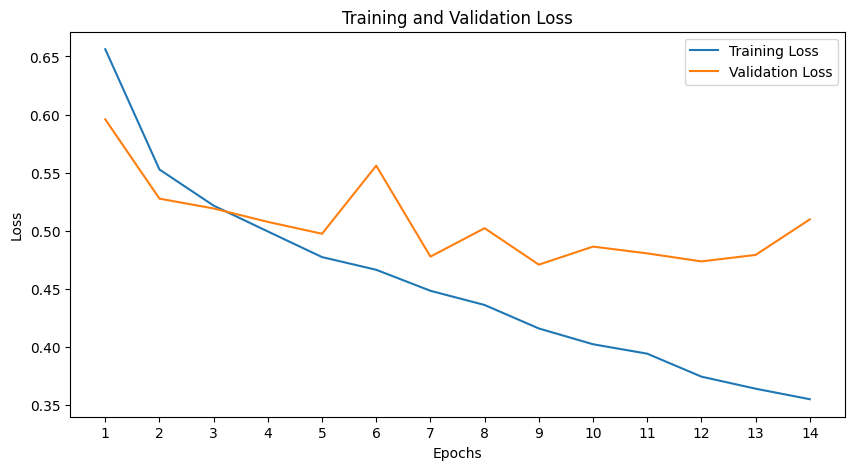

SentimentRNN(
  (embedding): Embedding(18031, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
)

In [25]:
# Instantiate the model
rnn_model = SentimentRNN(embedding_matrix)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rnn_model.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5, verbose=True)

# Training loop with validation and early stopping
num_epochs = 30
patience = 5  # Early stopping patience

train_model(rnn_model, 'rnn', num_epochs, optimizer, scheduler, criterion, patience, train_loader, val_loader, device)      

In [26]:
# Load the best model and evaluate on the test set
rnn_model.load_state_dict(torch.load('rnn_model.pt'))
test_model(rnn_model,device, test_loader)

C:\Users\zheng\AppData\Local\Temp\ipykernel_49844\2246774384.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rnn_model.load_state_dict(torch.load('rnn_model.pt'))
100%|█

Accuracy Score on Test dataset: 0.7702


## Part 2c) Methods used in deriving the final sentence representation

### Part 2c.1) Method 1: Max-Pooling

In [27]:
class SentimentRNNWithMaxPooling(nn.Module):
    def __init__(self, embedding_matrix):
        super(SentimentRNNWithMaxPooling, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=True)
        self.lstm = nn.LSTM(embedding_dim, hidden_size=256, batch_first=True, bidirectional=False, num_layers=2, dropout=0.5)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, _ = self.lstm(embeds)

        max_pool, _ = torch.max(lstm_out, dim = 1) #Considers the maximum output of all analyzed LSTM layers to determine the final result.

        out = self.dropout(max_pool)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = torch.sigmoid(self.fc2(out))
        return out.squeeze()

100%|██████████| 9/9 [00:00<00:00, 37.29it/s]


Epoch [1/30], Training Loss: 0.6673, Validation Accuracy: 0.6698, Validation Loss: 0.6218, Best Val Loss: inf


100%|██████████| 9/9 [00:00<00:00, 41.59it/s]


Epoch [2/30], Training Loss: 0.5741, Validation Accuracy: 0.7486, Validation Loss: 0.5530, Best Val Loss: 0.6218


100%|██████████| 9/9 [00:00<00:00, 44.02it/s]


Epoch [3/30], Training Loss: 0.5261, Validation Accuracy: 0.7561, Validation Loss: 0.5210, Best Val Loss: 0.5530


100%|██████████| 9/9 [00:00<00:00, 41.02it/s]


Epoch [4/30], Training Loss: 0.5073, Validation Accuracy: 0.7430, Validation Loss: 0.5175, Best Val Loss: 0.5210


100%|██████████| 9/9 [00:00<00:00, 41.78it/s]


Epoch [5/30], Training Loss: 0.4817, Validation Accuracy: 0.7552, Validation Loss: 0.4925, Best Val Loss: 0.5175


100%|██████████| 9/9 [00:00<00:00, 45.12it/s]


Epoch [6/30], Training Loss: 0.4673, Validation Accuracy: 0.7598, Validation Loss: 0.4977, Best Val Loss: 0.4925


100%|██████████| 9/9 [00:00<00:00, 45.58it/s]


Epoch [7/30], Training Loss: 0.4613, Validation Accuracy: 0.7664, Validation Loss: 0.4987, Best Val Loss: 0.4925


100%|██████████| 9/9 [00:00<00:00, 40.47it/s]


Epoch [8/30], Training Loss: 0.4385, Validation Accuracy: 0.7505, Validation Loss: 0.4914, Best Val Loss: 0.4925


100%|██████████| 9/9 [00:00<00:00, 44.67it/s]


Epoch [9/30], Training Loss: 0.4371, Validation Accuracy: 0.7655, Validation Loss: 0.5026, Best Val Loss: 0.4914


100%|██████████| 9/9 [00:00<00:00, 43.39it/s]


Epoch [10/30], Training Loss: 0.4163, Validation Accuracy: 0.7645, Validation Loss: 0.5247, Best Val Loss: 0.4914


100%|██████████| 9/9 [00:00<00:00, 46.76it/s]


Epoch [11/30], Training Loss: 0.3916, Validation Accuracy: 0.7674, Validation Loss: 0.5129, Best Val Loss: 0.4914


100%|██████████| 9/9 [00:00<00:00, 46.04it/s]


Epoch [12/30], Training Loss: 0.3729, Validation Accuracy: 0.7664, Validation Loss: 0.5070, Best Val Loss: 0.4914


100%|██████████| 9/9 [00:00<00:00, 43.59it/s]


Epoch [13/30], Training Loss: 0.3616, Validation Accuracy: 0.7561, Validation Loss: 0.5689, Best Val Loss: 0.4914
Early stopping!


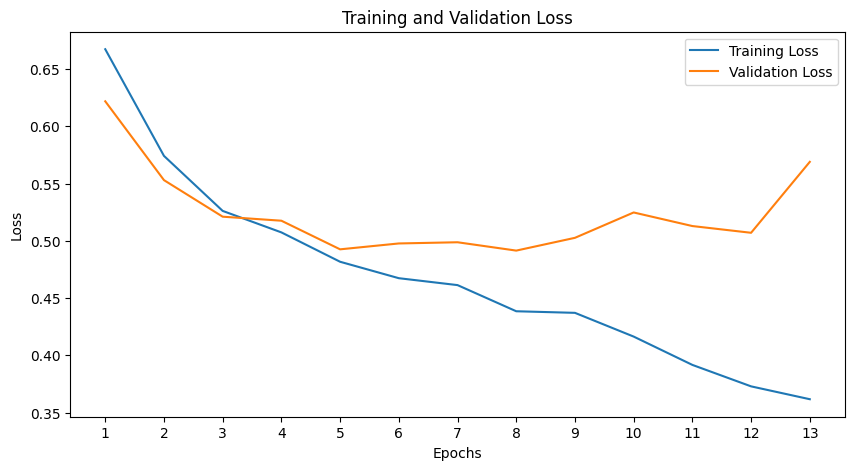

SentimentRNNWithMaxPooling(
  (embedding): Embedding(18031, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

In [28]:
# Instantiate the model
rnn_model = SentimentRNNWithMaxPooling(embedding_matrix)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rnn_model.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5, verbose=True)

# Training loop with validation and early stopping
num_epochs = 30
patience = 5  # Early stopping patience

train_model(rnn_model, 'maxpooling', num_epochs, optimizer, scheduler, criterion, patience, train_loader, val_loader, device)      

In [29]:
# Load the best model and evaluate on the test set
rnn_model.load_state_dict(torch.load('maxpooling_model.pt'))
test_model(rnn_model,device, test_loader)

C:\Users\zheng\AppData\Local\Temp\ipykernel_49844\4287298740.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rnn_model.load_state_dict(torch.load('maxpooling_model.pt'))

Accuracy Score on Test dataset: 0.7739


### Part 2c.2) Method 2: Mean-Pooling

In [30]:
class SentimentRNNWithAvgPooling(nn.Module):
    def __init__(self, embedding_matrix):
        super(SentimentRNNWithAvgPooling, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=True)
        self.lstm = nn.LSTM(embedding_dim, hidden_size=256, batch_first=True, bidirectional=False, num_layers=2, dropout=0.5)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, _ = self.lstm(embeds)

        mean_pool= lstm_out.mean(dim = 1) #Considers the mean output of all analyzed LSTM layers to determine the final result.

        out = self.dropout(mean_pool)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = torch.sigmoid(self.fc2(out))
        return out.squeeze()

100%|██████████| 9/9 [00:00<00:00, 46.52it/s]


Epoch [1/30], Training Loss: 0.6615, Validation Accuracy: 0.6857, Validation Loss: 0.6921, Best Val Loss: inf


100%|██████████| 9/9 [00:00<00:00, 46.76it/s]


Epoch [2/30], Training Loss: 0.5759, Validation Accuracy: 0.7205, Validation Loss: 0.5454, Best Val Loss: 0.6921


100%|██████████| 9/9 [00:00<00:00, 44.90it/s]


Epoch [3/30], Training Loss: 0.5450, Validation Accuracy: 0.7298, Validation Loss: 0.5438, Best Val Loss: 0.5454


100%|██████████| 9/9 [00:00<00:00, 39.58it/s]


Epoch [4/30], Training Loss: 0.5204, Validation Accuracy: 0.7289, Validation Loss: 0.5212, Best Val Loss: 0.5438


100%|██████████| 9/9 [00:00<00:00, 40.83it/s]


Epoch [5/30], Training Loss: 0.5122, Validation Accuracy: 0.7383, Validation Loss: 0.5221, Best Val Loss: 0.5212


100%|██████████| 9/9 [00:00<00:00, 44.68it/s]


Epoch [6/30], Training Loss: 0.4959, Validation Accuracy: 0.7364, Validation Loss: 0.5135, Best Val Loss: 0.5212


100%|██████████| 9/9 [00:00<00:00, 45.58it/s]


Epoch [7/30], Training Loss: 0.4766, Validation Accuracy: 0.7467, Validation Loss: 0.5024, Best Val Loss: 0.5135


100%|██████████| 9/9 [00:00<00:00, 43.39it/s]


Epoch [8/30], Training Loss: 0.4718, Validation Accuracy: 0.7523, Validation Loss: 0.5244, Best Val Loss: 0.5024


100%|██████████| 9/9 [00:00<00:00, 44.45it/s]


Epoch [9/30], Training Loss: 0.4569, Validation Accuracy: 0.7392, Validation Loss: 0.5791, Best Val Loss: 0.5024


100%|██████████| 9/9 [00:00<00:00, 45.58it/s]


Epoch [10/30], Training Loss: 0.4461, Validation Accuracy: 0.7683, Validation Loss: 0.5088, Best Val Loss: 0.5024


100%|██████████| 9/9 [00:00<00:00, 44.45it/s]


Epoch [11/30], Training Loss: 0.4444, Validation Accuracy: 0.7580, Validation Loss: 0.4818, Best Val Loss: 0.5024


100%|██████████| 9/9 [00:00<00:00, 48.26it/s]


Epoch [12/30], Training Loss: 0.4335, Validation Accuracy: 0.7514, Validation Loss: 0.5258, Best Val Loss: 0.4818


100%|██████████| 9/9 [00:00<00:00, 42.57it/s]


Epoch [13/30], Training Loss: 0.4293, Validation Accuracy: 0.7692, Validation Loss: 0.4817, Best Val Loss: 0.4818


100%|██████████| 9/9 [00:00<00:00, 41.02it/s]


Epoch [14/30], Training Loss: 0.4158, Validation Accuracy: 0.7627, Validation Loss: 0.4716, Best Val Loss: 0.4817


100%|██████████| 9/9 [00:00<00:00, 41.59it/s]


Epoch [15/30], Training Loss: 0.4037, Validation Accuracy: 0.7739, Validation Loss: 0.4760, Best Val Loss: 0.4716


100%|██████████| 9/9 [00:00<00:00, 45.12it/s]


Epoch [16/30], Training Loss: 0.3895, Validation Accuracy: 0.7617, Validation Loss: 0.4976, Best Val Loss: 0.4716


100%|██████████| 9/9 [00:00<00:00, 41.97it/s]


Epoch [17/30], Training Loss: 0.3901, Validation Accuracy: 0.7758, Validation Loss: 0.5297, Best Val Loss: 0.4716


100%|██████████| 9/9 [00:00<00:00, 43.80it/s]


Epoch [18/30], Training Loss: 0.3907, Validation Accuracy: 0.7777, Validation Loss: 0.5420, Best Val Loss: 0.4716


100%|██████████| 9/9 [00:00<00:00, 44.90it/s]


Epoch [19/30], Training Loss: 0.3717, Validation Accuracy: 0.7805, Validation Loss: 0.4934, Best Val Loss: 0.4716
Early stopping!


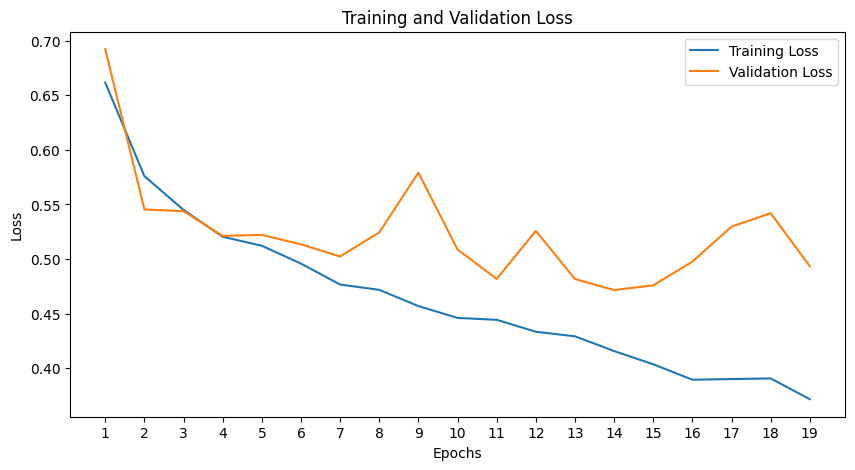

SentimentRNNWithAvgPooling(
  (embedding): Embedding(18031, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

In [31]:
# Instantiate the model
rnn_model = SentimentRNNWithAvgPooling(embedding_matrix)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rnn_model.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5, verbose=True)

# Training loop with validation and early stopping
num_epochs = 30
patience = 5  # Early stopping patience

train_model(rnn_model, 'meanpooling', num_epochs, optimizer, scheduler, criterion, patience, train_loader, val_loader, device)      

In [32]:
# Load the best model and evaluate on the test set
rnn_model.load_state_dict(torch.load('meanpooling_model.pt'))
test_model(rnn_model,device, test_loader)

C:\Users\zheng\AppData\Local\Temp\ipykernel_49844\2809441753.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rnn_model.load_state_dict(torch.load('meanpooling_model.pt')

Accuracy Score on Test dataset: 0.7674


### Part 2c.3) Method 3: Simple Attention Mechanism

In [33]:
class SimpleAttention(nn.Module):
  def __init__(self, hidden_size):
      super(SimpleAttention, self).__init__()
      self.weight = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
      self.bias = nn.Parameter(torch.Tensor(hidden_size))

  def forward(self, hidden_states):
      # hidden_states: [batch_size, seq_len, hidden_size]
      batch_size, seq_len, hidden_size = hidden_states.size()

      # Calculate attention weights
      weights = torch.bmm(hidden_states, self.weight.unsqueeze(0).repeat(batch_size, 1, 1))
      weights = torch.tanh(weights + self.bias.unsqueeze(0).unsqueeze(1).repeat(batch_size, seq_len, 1))
      weights = torch.softmax(weights, dim=1)  # Normalize weights

      # Weight the hidden states
      weighted_hidden_states = hidden_states * weights

      # Aggregate the weighted hidden states
      context_vector = torch.sum(weighted_hidden_states, dim=1)  # Sum across time steps

      return context_vector


# Define the RNN model using pre-trained embeddings
class SentimentRNNWithSimpleAttention(nn.Module):
    def __init__(self, embedding_matrix):
        super(SentimentRNNWithSimpleAttention, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=True)
        self.lstm = nn.LSTM(embedding_dim, hidden_size=256, batch_first=True, bidirectional=False, num_layers=2, dropout=0.5)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.attention = SimpleAttention(hidden_size=256)

    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, (h_n, c_n) = self.lstm(embeds)

        # Apply Attention Mechanism
        context_vector = self.attention(lstm_out)

        context_vector = self.dropout(context_vector)
        context_vector = self.relu(self.fc1(context_vector))
        context_vector = self.dropout(context_vector)
        context_vector = torch.sigmoid(self.fc2(context_vector))
        return context_vector.squeeze()

100%|██████████| 9/9 [00:00<00:00, 40.83it/s]


Epoch [1/30], Training Loss: 0.6834, Validation Accuracy: 0.5281, Validation Loss: 0.6821, Best Val Loss: inf


100%|██████████| 9/9 [00:00<00:00, 41.59it/s]


Epoch [2/30], Training Loss: 0.5998, Validation Accuracy: 0.7092, Validation Loss: 0.5662, Best Val Loss: 0.6821


100%|██████████| 9/9 [00:00<00:00, 44.67it/s]


Epoch [3/30], Training Loss: 0.5460, Validation Accuracy: 0.7195, Validation Loss: 0.5385, Best Val Loss: 0.5662


100%|██████████| 9/9 [00:00<00:00, 39.41it/s]


Epoch [4/30], Training Loss: 0.5165, Validation Accuracy: 0.7383, Validation Loss: 0.5359, Best Val Loss: 0.5385


100%|██████████| 9/9 [00:00<00:00, 44.45it/s]


Epoch [5/30], Training Loss: 0.4990, Validation Accuracy: 0.7120, Validation Loss: 0.5541, Best Val Loss: 0.5359


100%|██████████| 9/9 [00:00<00:00, 45.13it/s]


Epoch [6/30], Training Loss: 0.4892, Validation Accuracy: 0.7336, Validation Loss: 0.5597, Best Val Loss: 0.5359


100%|██████████| 9/9 [00:00<00:00, 42.37it/s]


Epoch [7/30], Training Loss: 0.4759, Validation Accuracy: 0.7580, Validation Loss: 0.4970, Best Val Loss: 0.5359


100%|██████████| 9/9 [00:00<00:00, 46.76it/s]


Epoch [8/30], Training Loss: 0.4620, Validation Accuracy: 0.7505, Validation Loss: 0.4837, Best Val Loss: 0.4970


100%|██████████| 9/9 [00:00<00:00, 47.25it/s]


Epoch [9/30], Training Loss: 0.4446, Validation Accuracy: 0.7495, Validation Loss: 0.5022, Best Val Loss: 0.4837


100%|██████████| 9/9 [00:00<00:00, 44.90it/s]


Epoch [10/30], Training Loss: 0.4447, Validation Accuracy: 0.7683, Validation Loss: 0.4758, Best Val Loss: 0.4837


100%|██████████| 9/9 [00:00<00:00, 39.93it/s]


Epoch [11/30], Training Loss: 0.4413, Validation Accuracy: 0.7608, Validation Loss: 0.5981, Best Val Loss: 0.4758


100%|██████████| 9/9 [00:00<00:00, 41.58it/s]


Epoch [12/30], Training Loss: 0.4366, Validation Accuracy: 0.7777, Validation Loss: 0.5097, Best Val Loss: 0.4758


100%|██████████| 9/9 [00:00<00:00, 40.25it/s]


Epoch [13/30], Training Loss: 0.4117, Validation Accuracy: 0.7730, Validation Loss: 0.4707, Best Val Loss: 0.4758


100%|██████████| 9/9 [00:00<00:00, 43.17it/s]


Epoch [14/30], Training Loss: 0.3978, Validation Accuracy: 0.7833, Validation Loss: 0.4764, Best Val Loss: 0.4707


100%|██████████| 9/9 [00:00<00:00, 41.78it/s]


Epoch [15/30], Training Loss: 0.3861, Validation Accuracy: 0.7777, Validation Loss: 0.5278, Best Val Loss: 0.4707


100%|██████████| 9/9 [00:00<00:00, 32.46it/s]


Epoch [16/30], Training Loss: 0.3888, Validation Accuracy: 0.7786, Validation Loss: 0.4767, Best Val Loss: 0.4707


100%|██████████| 9/9 [00:00<00:00, 38.73it/s]


Epoch [17/30], Training Loss: 0.3675, Validation Accuracy: 0.7711, Validation Loss: 0.4883, Best Val Loss: 0.4707


100%|██████████| 9/9 [00:00<00:00, 42.57it/s]


Epoch [18/30], Training Loss: 0.3432, Validation Accuracy: 0.7720, Validation Loss: 0.5236, Best Val Loss: 0.4707
Early stopping!


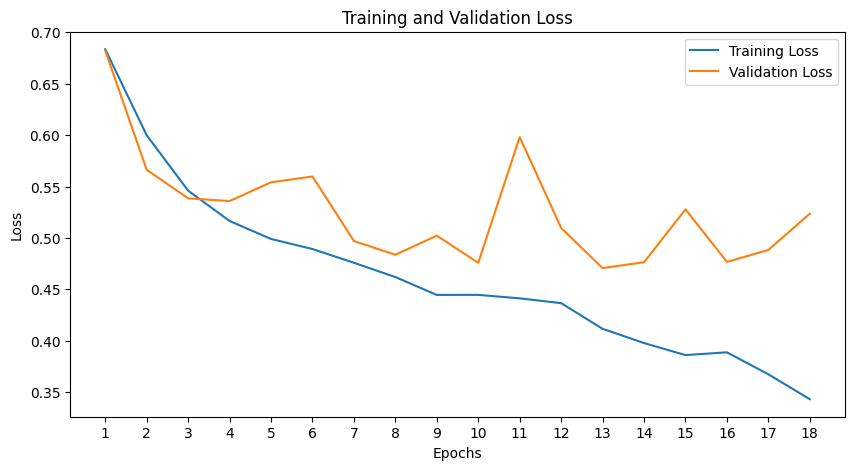

SentimentRNNWithSimpleAttention(
  (embedding): Embedding(18031, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (attention): SimpleAttention()
)

In [34]:
# Instantiate the model
rnn_model = SentimentRNNWithSimpleAttention(embedding_matrix)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rnn_model.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5, verbose=True)

# Training loop with validation and early stopping
num_epochs = 30
patience = 5  # Early stopping patience

train_model(rnn_model, 'simpleattention', num_epochs, optimizer, scheduler, criterion, patience, train_loader, val_loader, device)      

In [35]:
# Load the best model and evaluate on the test set
rnn_model.load_state_dict(torch.load('simpleattention_model.pt'))
test_model(rnn_model,device, test_loader)

C:\Users\zheng\AppData\Local\Temp\ipykernel_49844\1379173986.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rnn_model.load_state_dict(torch.load('simpleattention_model.

Accuracy Score on Test dataset: 0.7786


### Part 2c.4) Method 4: Self-Attention Mechanism

In [36]:
class SelfAttention(nn.Module):
  def __init__(self, hidden_size):
      super(SelfAttention, self).__init__()
      self.query = nn.Linear(hidden_size, hidden_size)  # Linear layer for query
      self.key = nn.Linear(hidden_size, hidden_size)    # Linear layer for key
      self.value = nn.Linear(hidden_size, hidden_size)  # Linear layer for value

  def forward(self, hidden_states):
      # hidden_states: [batch_size, seq_len, hidden_size]
      batch_size, seq_len, hidden_size = hidden_states.size()

      # Calculate vectors
      Q = self.query(hidden_states)
      K = self.key(hidden_states)
      V = self.value(hidden_states)

      # Calculate attention weights
      attention_weights = torch.bmm(Q, K.transpose(1, 2)) / (hidden_size ** 0.5)
      attention_weights = torch.softmax(attention_weights, dim=-1)

      # Weight the value vectors by attention weights
      weighted_values = torch.bmm(attention_weights, V)

      return weighted_values

class SimpleAttention(nn.Module):
  def __init__(self, hidden_size):
      super(SimpleAttention, self).__init__()
      self.weight = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
      self.bias = nn.Parameter(torch.Tensor(hidden_size))

  def forward(self, hidden_states):
      # hidden_states: [batch_size, seq_len, hidden_size]
      batch_size, seq_len, hidden_size = hidden_states.size()

      # Calculate attention weights
      weights = torch.bmm(hidden_states, self.weight.unsqueeze(0).repeat(batch_size, 1, 1))
      weights = torch.tanh(weights + self.bias.unsqueeze(0).unsqueeze(1).repeat(batch_size, seq_len, 1))
      weights = torch.softmax(weights, dim=1)  # Normalize weights

      # Weight the hidden states
      weighted_hidden_states = hidden_states * weights

      # Aggregate the weighted hidden states
      context_vector = torch.sum(weighted_hidden_states, dim=1)  # Sum across time steps

      return context_vector


# Define the RNN model using pre-trained embeddings
class SentimentRNNWithSelfAttention(nn.Module):
    def __init__(self, embedding_matrix):
        super(SentimentRNNWithSelfAttention, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=True)
        self.lstm = nn.LSTM(embedding_dim, hidden_size=256, batch_first=True, bidirectional=False, num_layers=2, dropout=0.5)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.self_attention = SelfAttention(hidden_size=256)
        self.simple_attention = SimpleAttention(hidden_size=256)

    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, (h_n, c_n) = self.lstm(embeds)

        # Apply self-attention
        self_attention_out = self.self_attention(lstm_out)

        # Apply Simple attention
        context_vector = self.simple_attention(self_attention_out)

        context_vector = self.dropout(context_vector)
        context_vector = self.relu(self.fc1(context_vector))
        context_vector = self.dropout(context_vector)
        context_vector = torch.sigmoid(self.fc2(context_vector))
        return context_vector.squeeze()

100%|██████████| 9/9 [00:00<00:00, 44.45it/s]


Epoch [1/30], Training Loss: 0.6684, Validation Accuracy: 0.6857, Validation Loss: 0.6281, Best Val Loss: inf


100%|██████████| 9/9 [00:00<00:00, 39.24it/s]


Epoch [2/30], Training Loss: 0.5849, Validation Accuracy: 0.6876, Validation Loss: 0.5800, Best Val Loss: 0.6281


100%|██████████| 9/9 [00:00<00:00, 42.57it/s]


Epoch [3/30], Training Loss: 0.5440, Validation Accuracy: 0.7092, Validation Loss: 0.5648, Best Val Loss: 0.5800


100%|██████████| 9/9 [00:00<00:00, 42.97it/s]


Epoch [4/30], Training Loss: 0.5200, Validation Accuracy: 0.7364, Validation Loss: 0.5250, Best Val Loss: 0.5648


100%|██████████| 9/9 [00:00<00:00, 35.81it/s]


Epoch [5/30], Training Loss: 0.5054, Validation Accuracy: 0.7092, Validation Loss: 0.5804, Best Val Loss: 0.5250


100%|██████████| 9/9 [00:00<00:00, 37.44it/s]


Epoch [6/30], Training Loss: 0.4894, Validation Accuracy: 0.7495, Validation Loss: 0.5057, Best Val Loss: 0.5250


100%|██████████| 9/9 [00:00<00:00, 43.17it/s]


Epoch [7/30], Training Loss: 0.4737, Validation Accuracy: 0.7598, Validation Loss: 0.4982, Best Val Loss: 0.5057


100%|██████████| 9/9 [00:00<00:00, 40.83it/s]


Epoch [8/30], Training Loss: 0.4705, Validation Accuracy: 0.7617, Validation Loss: 0.5152, Best Val Loss: 0.4982


100%|██████████| 9/9 [00:00<00:00, 37.92it/s]


Epoch [9/30], Training Loss: 0.4564, Validation Accuracy: 0.7655, Validation Loss: 0.4997, Best Val Loss: 0.4982


100%|██████████| 9/9 [00:00<00:00, 43.38it/s]


Epoch [10/30], Training Loss: 0.4588, Validation Accuracy: 0.7720, Validation Loss: 0.4763, Best Val Loss: 0.4982


100%|██████████| 9/9 [00:00<00:00, 38.90it/s]


Epoch [11/30], Training Loss: 0.4413, Validation Accuracy: 0.7477, Validation Loss: 0.5350, Best Val Loss: 0.4763


100%|██████████| 9/9 [00:00<00:00, 41.02it/s]


Epoch [12/30], Training Loss: 0.4302, Validation Accuracy: 0.7739, Validation Loss: 0.5041, Best Val Loss: 0.4763


100%|██████████| 9/9 [00:00<00:00, 39.58it/s]


Epoch [13/30], Training Loss: 0.4280, Validation Accuracy: 0.7739, Validation Loss: 0.4765, Best Val Loss: 0.4763


100%|██████████| 9/9 [00:00<00:00, 42.77it/s]


Epoch [14/30], Training Loss: 0.4201, Validation Accuracy: 0.7852, Validation Loss: 0.4673, Best Val Loss: 0.4763


100%|██████████| 9/9 [00:00<00:00, 43.81it/s]


Epoch [15/30], Training Loss: 0.4090, Validation Accuracy: 0.7683, Validation Loss: 0.4652, Best Val Loss: 0.4673


100%|██████████| 9/9 [00:00<00:00, 39.41it/s]


Epoch [16/30], Training Loss: 0.3977, Validation Accuracy: 0.7908, Validation Loss: 0.4668, Best Val Loss: 0.4652


100%|██████████| 9/9 [00:00<00:00, 43.18it/s]


Epoch [17/30], Training Loss: 0.3885, Validation Accuracy: 0.7767, Validation Loss: 0.5041, Best Val Loss: 0.4652


100%|██████████| 9/9 [00:00<00:00, 41.59it/s]


Epoch [18/30], Training Loss: 0.3746, Validation Accuracy: 0.7917, Validation Loss: 0.4569, Best Val Loss: 0.4652


100%|██████████| 9/9 [00:00<00:00, 41.02it/s]


Epoch [19/30], Training Loss: 0.3743, Validation Accuracy: 0.7795, Validation Loss: 0.4983, Best Val Loss: 0.4569


100%|██████████| 9/9 [00:00<00:00, 40.65it/s]


Epoch [20/30], Training Loss: 0.3610, Validation Accuracy: 0.7805, Validation Loss: 0.4729, Best Val Loss: 0.4569


100%|██████████| 9/9 [00:00<00:00, 44.24it/s]


Epoch [21/30], Training Loss: 0.3433, Validation Accuracy: 0.7692, Validation Loss: 0.5343, Best Val Loss: 0.4569


100%|██████████| 9/9 [00:00<00:00, 37.14it/s]


Epoch [22/30], Training Loss: 0.3063, Validation Accuracy: 0.7917, Validation Loss: 0.5070, Best Val Loss: 0.4569


100%|██████████| 9/9 [00:00<00:00, 39.41it/s]


Epoch [23/30], Training Loss: 0.2911, Validation Accuracy: 0.7739, Validation Loss: 0.5336, Best Val Loss: 0.4569
Early stopping!


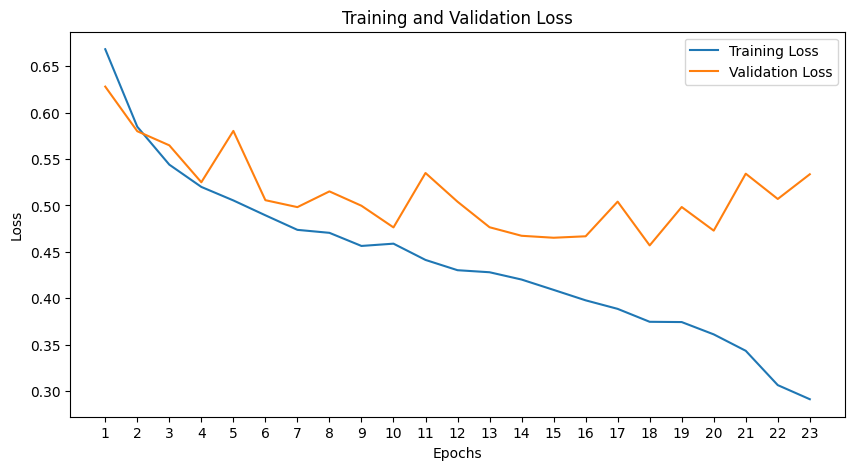

SentimentRNNWithSelfAttention(
  (embedding): Embedding(18031, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (self_attention): SelfAttention(
    (query): Linear(in_features=256, out_features=256, bias=True)
    (key): Linear(in_features=256, out_features=256, bias=True)
    (value): Linear(in_features=256, out_features=256, bias=True)
  )
  (simple_attention): SimpleAttention()
)

In [37]:
# Instantiate the model
rnn_model = SentimentRNNWithSelfAttention(embedding_matrix)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rnn_model.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5, verbose=True)

# Training loop with validation and early stopping
num_epochs = 30
patience = 5  # Early stopping patience

train_model(rnn_model, 'selfattention', num_epochs, optimizer, scheduler, criterion, patience, train_loader, val_loader, device)      

In [38]:
# Load the best model and evaluate on the test set
rnn_model.load_state_dict(torch.load('selfattention_model.pt'))
test_model(rnn_model,device, test_loader)

C:\Users\zheng\AppData\Local\Temp\ipykernel_49844\650248929.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rnn_model.load_state_dict(torch.load('selfattention_model.pt'

Accuracy Score on Test dataset: 0.7842


# Part 3 Enhancement

## Part 3.1 Word Embeddings Updated

In [39]:
# Load the dataset
dataset = load_dataset("rotten_tomatoes")
train_raw = dataset['train']
validation_raw = dataset['validation']
test_raw = dataset['test']

# Build the vocabulary from training data
vocabulary = set()
for text in train_raw['text']:
    tokens = word_tokenize(text.lower())
    vocabulary.update(tokens)

# Add special tokens
vocabulary.add('<unk>')
vocabulary.add('<pad>')

# Create mappings between words and indices
word2idx = {word: idx for idx, word in enumerate(vocabulary)}
idx2word = {idx: word for word, idx in word2idx.items()}

# Initialize the embedding matrix
embedding_dim = 100  # Dimensionality of GloVe embeddings
vocab_size = len(word2idx)
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Load GloVe embeddings (ensure 'glove.6B.100d.txt' is in your working directory)
glove_path = 'glove.6B.100d.txt'  # Update the path if necessary
with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        if len(values) == embedding_dim + 1:
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            if word in word2idx:
                idx = word2idx[word]
                embedding_matrix[idx] = vector

# Set the embedding for '<pad>' token to zeros
pad_idx = word2idx['<pad>']
embedding_matrix[pad_idx] = np.zeros(embedding_dim)

In [40]:
# Define the RNN model using pre-trained embeddings
class SentimentRNNUpdatedEmbeddings(nn.Module):
    def __init__(self, embedding_matrix):
        super(SentimentRNNUpdatedEmbeddings, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze= False)
        self.lstm = nn.LSTM(embedding_dim, hidden_size=256, batch_first=True, bidirectional=False, num_layers=2, dropout=0.5)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, (h_n, c_n) = self.lstm(embeds)

        out, _ = torch.max(lstm_out, dim=1)
        # Concatenate the final hidden states from both directions
        # out = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)
        
        out = self.dropout(out)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = torch.sigmoid(self.fc2(out))
        return out.squeeze()

100%|██████████| 9/9 [00:00<00:00, 44.67it/s]


Epoch [1/30], Training Loss: 0.6661, Validation Accuracy: 0.6735, Validation Loss: 0.6270, Best Val Loss: inf


100%|██████████| 9/9 [00:00<00:00, 41.59it/s]


Epoch [2/30], Training Loss: 0.5466, Validation Accuracy: 0.7298, Validation Loss: 0.5282, Best Val Loss: 0.6270


100%|██████████| 9/9 [00:00<00:00, 41.39it/s]


Epoch [3/30], Training Loss: 0.4712, Validation Accuracy: 0.7664, Validation Loss: 0.4881, Best Val Loss: 0.5282


100%|██████████| 9/9 [00:00<00:00, 43.81it/s]


Epoch [4/30], Training Loss: 0.3700, Validation Accuracy: 0.7655, Validation Loss: 0.4775, Best Val Loss: 0.4881


100%|██████████| 9/9 [00:00<00:00, 46.04it/s]


Epoch [5/30], Training Loss: 0.2863, Validation Accuracy: 0.7674, Validation Loss: 0.5048, Best Val Loss: 0.4775


100%|██████████| 9/9 [00:00<00:00, 43.18it/s]


Epoch [6/30], Training Loss: 0.2196, Validation Accuracy: 0.7730, Validation Loss: 0.5257, Best Val Loss: 0.4775


100%|██████████| 9/9 [00:00<00:00, 45.58it/s]


Epoch [7/30], Training Loss: 0.1638, Validation Accuracy: 0.7777, Validation Loss: 0.5762, Best Val Loss: 0.4775


100%|██████████| 9/9 [00:00<00:00, 44.89it/s]


Epoch [8/30], Training Loss: 0.1138, Validation Accuracy: 0.7542, Validation Loss: 0.7301, Best Val Loss: 0.4775


100%|██████████| 9/9 [00:00<00:00, 43.81it/s]


Epoch [9/30], Training Loss: 0.0779, Validation Accuracy: 0.7664, Validation Loss: 0.9045, Best Val Loss: 0.4775
Early stopping!


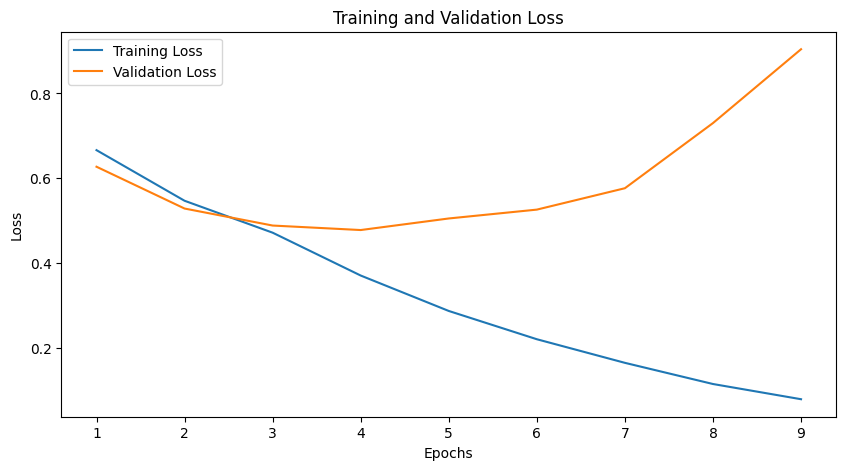

SentimentRNNUpdatedEmbeddings(
  (embedding): Embedding(18031, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
)

In [41]:
# Instantiate the model
sentimentRNNUpdatedEmbeddings = SentimentRNNUpdatedEmbeddings(embedding_matrix)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sentimentRNNUpdatedEmbeddings.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(sentimentRNNUpdatedEmbeddings.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5, verbose=True)

# Training loop with validation and early stopping
num_epochs = 30
patience = 5  # Early stopping patience

train_model(sentimentRNNUpdatedEmbeddings,'rnn', num_epochs, optimizer, scheduler, criterion, patience, train_loader, val_loader, device)

In [42]:
# Load the best model and evaluate on the test set
sentimentRNNUpdatedEmbeddings.load_state_dict(torch.load('rnn_model.pt'))
test_model(sentimentRNNUpdatedEmbeddings,device, test_loader)

C:\Users\zheng\AppData\Local\Temp\ipykernel_49844\85543697.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sentimentRNNUpdatedEmbeddings.load_state_dict(torch.load('rnn_

Accuracy Score on Test dataset: 0.7927


## Part 3.2 OOV Strategy 1: Random Embeddings 

In [43]:
# Load the dataset
dataset = load_dataset("rotten_tomatoes")
train_raw = dataset['train']
validation_raw = dataset['validation']
test_raw = dataset['test']

# Build the vocabulary from training data
vocabulary = set()
for text in train_raw['text']:
    tokens = word_tokenize(text.lower())
    vocabulary.update(tokens)

# Add special tokens
vocabulary.add('<unk>')
vocabulary.add('<pad>')

# Create mappings between words and indices
word2idx = {word: idx for idx, word in enumerate(vocabulary)}
idx2word = {idx: word for word, idx in word2idx.items()}

# Initialize the embedding matrix
embedding_dim = 100  # Dimensionality of GloVe embeddings
vocab_size = len(word2idx)
embedding_matrix = np.random.uniform(-0.05, 0.05, (vocab_size, embedding_dim))

# Load GloVe embeddings (ensure 'glove.6B.100d.txt' is in your working directory)
glove_path = 'glove.6B.100d.txt'  # Update the path if necessary
with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        if len(values) == embedding_dim + 1:
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            if word in word2idx:
                idx = word2idx[word]
                embedding_matrix[idx] = vector

# Set the embedding for '<pad>' token to zeros
pad_idx = word2idx['<pad>']
embedding_matrix[pad_idx] = np.zeros(embedding_dim)

100%|██████████| 9/9 [00:00<00:00, 38.40it/s]


Epoch [1/30], Training Loss: 0.6582, Validation Accuracy: 0.6660, Validation Loss: 0.6038, Best Val Loss: inf


100%|██████████| 9/9 [00:00<00:00, 42.17it/s]


Epoch [2/30], Training Loss: 0.5378, Validation Accuracy: 0.7448, Validation Loss: 0.5228, Best Val Loss: 0.6038


100%|██████████| 9/9 [00:00<00:00, 44.67it/s]


Epoch [3/30], Training Loss: 0.4244, Validation Accuracy: 0.7692, Validation Loss: 0.4825, Best Val Loss: 0.5228


100%|██████████| 9/9 [00:00<00:00, 44.67it/s]


Epoch [4/30], Training Loss: 0.3492, Validation Accuracy: 0.7824, Validation Loss: 0.4734, Best Val Loss: 0.4825


100%|██████████| 9/9 [00:00<00:00, 44.67it/s]


Epoch [5/30], Training Loss: 0.2716, Validation Accuracy: 0.7514, Validation Loss: 0.5161, Best Val Loss: 0.4734


100%|██████████| 9/9 [00:00<00:00, 45.13it/s]


Epoch [6/30], Training Loss: 0.2094, Validation Accuracy: 0.7674, Validation Loss: 0.5624, Best Val Loss: 0.4734


100%|██████████| 9/9 [00:00<00:00, 45.35it/s]


Epoch [7/30], Training Loss: 0.1485, Validation Accuracy: 0.7692, Validation Loss: 0.6156, Best Val Loss: 0.4734


100%|██████████| 9/9 [00:00<00:00, 45.57it/s]


Epoch [8/30], Training Loss: 0.0876, Validation Accuracy: 0.7824, Validation Loss: 0.7447, Best Val Loss: 0.4734


100%|██████████| 9/9 [00:00<00:00, 45.25it/s]


Epoch [9/30], Training Loss: 0.0606, Validation Accuracy: 0.7711, Validation Loss: 1.0141, Best Val Loss: 0.4734
Early stopping!


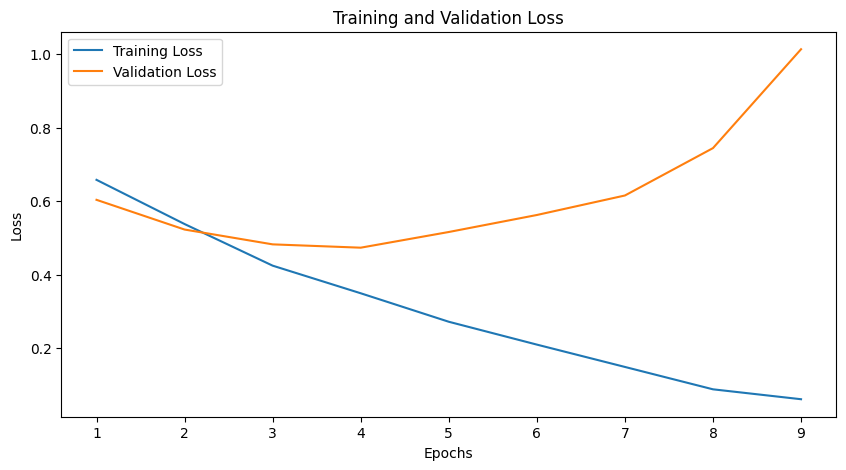

SentimentRNNUpdatedEmbeddings(
  (embedding): Embedding(18031, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
)

In [44]:
# Instantiate the model
sentimentRNNUpdatedEmbeddings = SentimentRNNUpdatedEmbeddings(embedding_matrix)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sentimentRNNUpdatedEmbeddings.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(sentimentRNNUpdatedEmbeddings.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5, verbose=True)

# Training loop with validation and early stopping
num_epochs = 30
patience = 5  # Early stopping patience

train_model(sentimentRNNUpdatedEmbeddings,'rnn', num_epochs, optimizer, scheduler, criterion, patience, train_loader, val_loader, device)

In [45]:
# Load the best model and evaluate on the test set
sentimentRNNUpdatedEmbeddings.load_state_dict(torch.load('rnn_model.pt'))
test_model(sentimentRNNUpdatedEmbeddings,device, test_loader)

C:\Users\zheng\AppData\Local\Temp\ipykernel_49844\85543697.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sentimentRNNUpdatedEmbeddings.load_state_dict(torch.load('rnn_

Accuracy Score on Test dataset: 0.8077


## Part 3.2 OOV Strategy 2: Byte-pair Encoding

In [46]:
# Load the Rotten Tomatoes dataset
dataset = load_dataset("rotten_tomatoes")
train_raw = dataset['train']
validation_raw = dataset['validation']
test_raw = dataset['test']

# Prepare the text data for BPE training
train_texts = [entry['text'] for entry in train_raw]

# Step 3: Initialize and Train the BPE Tokenizer
# Define a ByteLevelBPETokenizer instance
tokenizer = ByteLevelBPETokenizer()

# Train the tokenizer on the training texts
tokenizer.train_from_iterator(train_texts, vocab_size=30000, min_frequency=2)

# Save the trained tokenizer (optional)
tokenizer.save_model(".", "bpe_tokenizer")

# Step 4: Apply the Trained BPE Tokenizer to Your Datasets
# Tokenize a sample from the training set
train_tokenized = [tokenizer.encode(text).tokens for text in train_texts]

# Similarly tokenize the validation and test sets
validation_texts = [entry['text'] for entry in validation_raw]
validation_tokenized = [tokenizer.encode(text).tokens for text in validation_texts]

test_texts = [entry['text'] for entry in test_raw]
test_tokenized = [tokenizer.encode(text).tokens for text in test_texts]

# Print a sample tokenized text
print("Tokenized sample from training set:", train_tokenized[0])

Tokenized sample from training set: ['the', 'Ġrock', 'Ġis', 'Ġdestined', 'Ġto', 'Ġbe', 'Ġthe', 'Ġ21', 'st', 'Ġcentury', "'s", 'Ġnew', 'Ġ"', 'Ġconan', 'Ġ"', 'Ġand', 'Ġthat', 'Ġhe', "'s", 'Ġgoing', 'Ġto', 'Ġmake', 'Ġa', 'Ġsplash', 'Ġeven', 'Ġgreater', 'Ġthan', 'Ġarnold', 'Ġschwarzenegger', 'Ġ,', 'Ġjean', '-', 'cl', 'aud', 'Ġvan', 'Ġdamme', 'Ġor', 'Ġsteven', 'Ġse', 'gal', 'Ġ.']


In [47]:
def load_glove_embeddings(filepath):
    embeddings_index = {}
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

def get_subword_embedding(subwords, glove_embeddings, embedding_dim=100):
    vectors = []
    for subword in subwords:
        if subword in glove_embeddings:
            vectors.append(glove_embeddings[subword])
    if not vectors:
        # Handle the case where no subwords have embeddings
        return np.random.uniform(-0.05, 0.05, (embedding_dim,))
    # Average or sum the vectors
    return np.mean(vectors, axis=0)  # For averaging
    # return np.sum(vectors, axis=0)   # For summation

In [48]:
# Load the dataset
dataset = load_dataset("rotten_tomatoes")
train_raw = dataset['train']
validation_raw = dataset['validation']
test_raw = dataset['test']

# Build the vocabulary from training data
vocabulary = set()
for text in train_raw['text']:
    tokens = word_tokenize(text.lower())
    vocabulary.update(tokens)

# Add special tokens
vocabulary.add('<unk>')
vocabulary.add('<pad>')

# Create mappings between words and indices
word2idx = {word: idx for idx, word in enumerate(vocabulary)}
idx2word = {idx: word for word, idx in word2idx.items()}

# Initialize the embedding matrix
embedding_dim = 100  # Dimensionality of GloVe embeddings
vocab_size = len(word2idx)
embedding_matrix = np.random.uniform(-0.05, 0.05, (vocab_size, embedding_dim))

glove_embeddings = load_glove_embeddings('glove.6B.100d.txt')
tokenizer = ByteLevelBPETokenizer.from_file("bpe_tokenizer-vocab.json", "bpe_tokenizer-merges.txt")

for word in word2idx:
    idx = word2idx[word]
    if word in glove_embeddings:
        vector = glove_embeddings[word]
        embedding_matrix[idx] = vector

    else:
        subwords = tokenizer.encode(word).tokens
        # print(subwords)
        vector = get_subword_embedding(subwords=subwords, glove_embeddings=glove_embeddings)
        embedding_matrix[idx] = vector


# Set the embedding for '<pad>' token to zeros
pad_idx = word2idx['<pad>']
embedding_matrix[pad_idx] = np.zeros(embedding_dim)

100%|██████████| 9/9 [00:00<00:00, 48.26it/s]


Epoch [1/30], Training Loss: 0.6621, Validation Accuracy: 0.6932, Validation Loss: 0.6082, Best Val Loss: inf


100%|██████████| 9/9 [00:00<00:00, 48.00it/s]


Epoch [2/30], Training Loss: 0.5320, Validation Accuracy: 0.7430, Validation Loss: 0.5140, Best Val Loss: 0.6082


100%|██████████| 9/9 [00:00<00:00, 44.45it/s]


Epoch [3/30], Training Loss: 0.4385, Validation Accuracy: 0.7495, Validation Loss: 0.5023, Best Val Loss: 0.5140


100%|██████████| 9/9 [00:00<00:00, 47.75it/s]


Epoch [4/30], Training Loss: 0.3642, Validation Accuracy: 0.7758, Validation Loss: 0.5242, Best Val Loss: 0.5023


100%|██████████| 9/9 [00:00<00:00, 49.04it/s]


Epoch [5/30], Training Loss: 0.2826, Validation Accuracy: 0.7927, Validation Loss: 0.5093, Best Val Loss: 0.5023


100%|██████████| 9/9 [00:00<00:00, 48.52it/s]


Epoch [6/30], Training Loss: 0.2238, Validation Accuracy: 0.7899, Validation Loss: 0.5652, Best Val Loss: 0.5023


100%|██████████| 9/9 [00:00<00:00, 47.00it/s]


Epoch [7/30], Training Loss: 0.1679, Validation Accuracy: 0.7758, Validation Loss: 0.7315, Best Val Loss: 0.5023


100%|██████████| 9/9 [00:00<00:00, 48.52it/s]

Epoch [8/30], Training Loss: 0.1241, Validation Accuracy: 0.7730, Validation Loss: 0.7196, Best Val Loss: 0.5023
Early stopping!


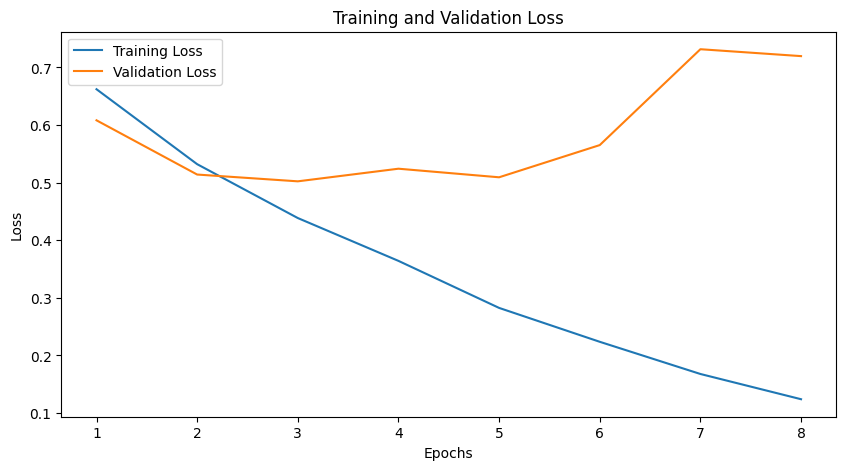

SentimentRNNUpdatedEmbeddings(
  (embedding): Embedding(18031, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
)

In [49]:
# Instantiate the model
sentimentRNNUpdatedEmbeddings = SentimentRNNUpdatedEmbeddings(embedding_matrix)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sentimentRNNUpdatedEmbeddings.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(sentimentRNNUpdatedEmbeddings.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5, verbose=True)

# Training loop with validation and early stopping
num_epochs = 30
patience = 5  # Early stopping patience

train_model(sentimentRNNUpdatedEmbeddings,'rnn', num_epochs, optimizer, scheduler, criterion, patience, train_loader, val_loader, device)

In [50]:
# Load the best model and evaluate on the test set
sentimentRNNUpdatedEmbeddings.load_state_dict(torch.load('rnn_model.pt'))
test_model(sentimentRNNUpdatedEmbeddings,device, test_loader)

C:\Users\zheng\AppData\Local\Temp\ipykernel_49844\85543697.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sentimentRNNUpdatedEmbeddings.load_state_dict(torch.load('rnn_

Accuracy Score on Test dataset: 0.7645


## Part 3.2 OOV Strategy 3: Backoff and Interpolation

In [51]:
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']
vocabulary = set()

for text in train_dataset['text']:
    tokens = word_tokenize(text.lower())
    vocabulary.update(tokens)

# Print the size of the vocabulary
print("The size of the vocabulary is:", len(vocabulary))

glove_vocab = set()
glove_embeddings = {}
embedding_dim = 100
with open('glove.6B.100d.txt', 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        glove_vocab.add(word)
        glove_embeddings[word] = np.asarray(values[1:], dtype='float32')

# Identify OOV words
oov_words = vocabulary - glove_vocab

vocabulary.add('<unk>')
vocabulary.add('<pad>')

# Create mappings between words and indices
word2idx = {word: idx for idx, word in enumerate(vocabulary)}
idx2word = {idx: word for idx, word in enumerate(vocabulary)}

# Initialize the embedding matrix for known words
embedding_matrix = np.zeros((len(vocabulary), embedding_dim))
for word in glove_vocab:
    if word in word2idx:  # Check if the word is in word2idx
        idx = word2idx[word]
        embedding_matrix[idx] = glove_embeddings[word]

        
embedding_matrix = np.zeros((len(vocabulary), embedding_dim))
for word in glove_vocab:
    if word in word2idx:  # Check if the word is in word2idx
        idx = word2idx[word]
        embedding_matrix[idx] = glove_embeddings[word]

        
# Create n-grams from training data
def create_ngrams(texts, n):
    ngram_counts = defaultdict(int)
    for entry in texts:  # Adjusted to iterate over each entry (dictionary)
        text = entry['text']  # Access the text with the appropriate key
        tokens = word_tokenize(text.lower())
        ngrams = zip(*[tokens[i:] for i in range(n)])  # Create n-grams
        for ngram in ngrams:
            ngram_counts[' '.join(ngram)] += 1
    return ngram_counts

# Create bigrams and trigrams
bigram_counts = create_ngrams(train_dataset, 2)  # Use train_raw directly
trigram_counts = create_ngrams(train_dataset, 3)  # Use train_raw directly

# Backoff and interpolation parameters
lambda1 = 0.8  # weight for unigrams
lambda2 = 0.15  # weight for bigrams
lambda3 = 0.05  # weight for trigrams

# Define a function for backoff and interpolation handling OOV words
def get_ngram_embedding(word, embedding_matrix, word2idx, bigram_counts, trigram_counts):
    if word in word2idx:
        return embedding_matrix[word2idx[word]]
    else:
        # Initialize embeddings for interpolation
        unigram_embedding = np.zeros(embedding_matrix.shape[1])
        bigram_embedding = np.zeros(embedding_matrix.shape[1])
        trigram_embedding = np.zeros(embedding_matrix.shape[1])
        
        # Check trigram context
        trigram_context = [ngram for ngram in trigram_counts if word in ngram.split()]
        if trigram_context:
            context_ngram = trigram_context[0].split()
            trigram_embedding = np.mean([embedding_matrix[word2idx[w]] for w in context_ngram if w in word2idx], axis=0)

        # Check bigram context
        bigram_context = [ngram for ngram in bigram_counts if word in ngram.split()]
        if bigram_context:
            context_ngram = bigram_context[0].split()
            bigram_embedding = np.mean([embedding_matrix[word2idx[w]] for w in context_ngram if w in word2idx], axis=0)

        # Calculate unigram embedding (mean of known embeddings, if available)
        known_words = [w for w in word2idx if w in vocabulary]
        if known_words:
            unigram_embedding = np.mean([embedding_matrix[word2idx[w]] for w in known_words if word2idx[w] < len(embedding_matrix)], axis=0)

        # Apply interpolation
        final_embedding = (lambda1 * unigram_embedding) + (lambda2 * bigram_embedding) + (lambda3 * trigram_embedding)
        return final_embedding

# Handle OOV words using n-gram embeddings
for oov_word in oov_words:
    if oov_word in word2idx:  # Ensure the OOV word exists in word2idx
        idx = word2idx[oov_word]
        embedding_matrix[idx] = get_ngram_embedding(oov_word, embedding_matrix, word2idx, bigram_counts, trigram_counts)

pad_idx = word2idx['<pad>']
embedding_matrix[pad_idx] = np.zeros(embedding_dim)

# Now, the embedding_matrix contains GloVe embeddings for known words and n-gram based embeddings for OOV words
print("Embedding matrix shape:", embedding_matrix.shape)

The size of the vocabulary is: 18029
Embedding matrix shape: (18031, 100)


100%|██████████| 9/9 [00:00<00:00, 40.65it/s]


Epoch [1/30], Training Loss: 0.6685, Validation Accuracy: 0.6660, Validation Loss: 0.6339, Best Val Loss: inf


100%|██████████| 9/9 [00:00<00:00, 47.00it/s]


Epoch [2/30], Training Loss: 0.5509, Validation Accuracy: 0.7411, Validation Loss: 0.5134, Best Val Loss: 0.6339


100%|██████████| 9/9 [00:00<00:00, 45.35it/s]


Epoch [3/30], Training Loss: 0.4598, Validation Accuracy: 0.7674, Validation Loss: 0.5129, Best Val Loss: 0.5134


100%|██████████| 9/9 [00:00<00:00, 49.31it/s]


Epoch [4/30], Training Loss: 0.3715, Validation Accuracy: 0.7795, Validation Loss: 0.4983, Best Val Loss: 0.5129


100%|██████████| 9/9 [00:00<00:00, 48.79it/s]


Epoch [5/30], Training Loss: 0.2987, Validation Accuracy: 0.7655, Validation Loss: 0.6024, Best Val Loss: 0.4983


100%|██████████| 9/9 [00:00<00:00, 47.00it/s]


Epoch [6/30], Training Loss: 0.2241, Validation Accuracy: 0.7814, Validation Loss: 0.5509, Best Val Loss: 0.4983


100%|██████████| 9/9 [00:00<00:00, 46.52it/s]


Epoch [7/30], Training Loss: 0.1631, Validation Accuracy: 0.7833, Validation Loss: 0.5935, Best Val Loss: 0.4983


100%|██████████| 9/9 [00:00<00:00, 45.38it/s]


Epoch [8/30], Training Loss: 0.1210, Validation Accuracy: 0.7645, Validation Loss: 0.7313, Best Val Loss: 0.4983


100%|██████████| 9/9 [00:00<00:00, 46.76it/s]


Epoch [9/30], Training Loss: 0.0842, Validation Accuracy: 0.7552, Validation Loss: 0.9012, Best Val Loss: 0.4983
Early stopping!


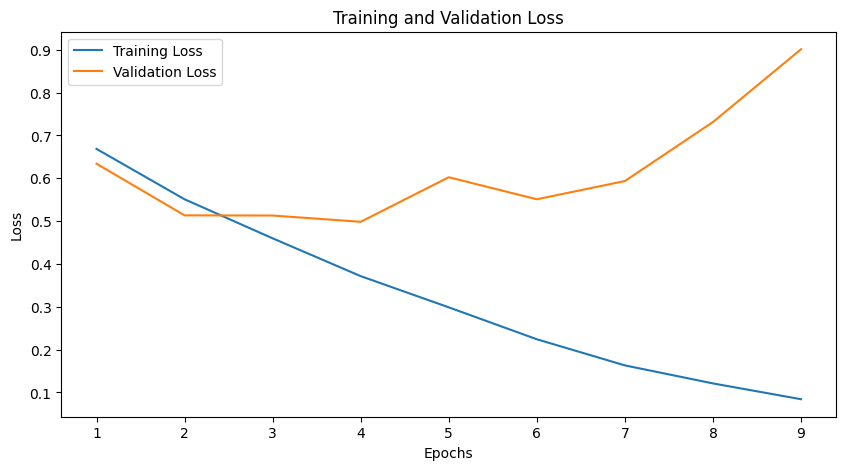

SentimentRNNUpdatedEmbeddings(
  (embedding): Embedding(18031, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
)

In [52]:
# Instantiate the model
sentimentRNNUpdatedEmbeddings = SentimentRNNUpdatedEmbeddings(embedding_matrix)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sentimentRNNUpdatedEmbeddings.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(sentimentRNNUpdatedEmbeddings.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5, verbose=True)

# Training loop with validation and early stopping
num_epochs = 30
patience = 5  # Early stopping patience

train_model(sentimentRNNUpdatedEmbeddings,'rnn', num_epochs, optimizer, scheduler, criterion, patience, train_loader, val_loader, device)

In [53]:
# Load the best model and evaluate on the test set
sentimentRNNUpdatedEmbeddings.load_state_dict(torch.load('rnn_model.pt'))
test_model(sentimentRNNUpdatedEmbeddings,device, test_loader)

C:\Users\zheng\AppData\Local\Temp\ipykernel_49844\85543697.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sentimentRNNUpdatedEmbeddings.load_state_dict(torch.load('rnn_

Accuracy Score on Test dataset: 0.7927


## Part 3.3 biLSTM model and a biGRU model

## Part 3.3.1 biLSTM Model

In [54]:
class SentimentLSTM(nn.Module):
    def __init__(self, embedding_matrix):
        super(SentimentLSTM, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze= False)
        self.lstm = nn.LSTM(embedding_dim, hidden_size=256, batch_first=True, bidirectional=True, num_layers=2, dropout=0.5)
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, (h_n, c_n) = self.lstm(embeds)

        out, _ = torch.max(lstm_out, dim=1)
        # Concatenate the final hidden states from both directions
        # out = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)
        
        out = self.dropout(out)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = torch.sigmoid(self.fc2(out))
        return out.squeeze()

In [55]:
# Load the dataset
dataset = load_dataset("rotten_tomatoes")
train_raw = dataset['train']
validation_raw = dataset['validation']
test_raw = dataset['test']

# Build the vocabulary from training data
vocabulary = set()
for text in train_raw['text']:
    tokens = word_tokenize(text.lower())
    vocabulary.update(tokens)

# Add special tokens
vocabulary.add('<unk>')
vocabulary.add('<pad>')

# Create mappings between words and indices
word2idx = {word: idx for idx, word in enumerate(vocabulary)}
idx2word = {idx: word for word, idx in word2idx.items()}

# Initialize the embedding matrix
embedding_dim = 100  # Dimensionality of GloVe embeddings
vocab_size = len(word2idx)
embedding_matrix = np.random.uniform(-0.05, 0.05, (vocab_size, embedding_dim))

# Load GloVe embeddings (ensure 'glove.6B.100d.txt' is in your working directory)
glove_path = 'glove.6B.100d.txt'  # Update the path if necessary
with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        if len(values) == embedding_dim + 1:
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            if word in word2idx:
                idx = word2idx[word]
                embedding_matrix[idx] = vector

# Set the embedding for '<pad>' token to zeros
pad_idx = word2idx['<pad>']
embedding_matrix[pad_idx] = np.zeros(embedding_dim)

100%|██████████| 9/9 [00:00<00:00, 41.21it/s]


Epoch [1/30], Training Loss: 0.6387, Validation Accuracy: 0.7176, Validation Loss: 0.6062, Best Val Loss: inf


100%|██████████| 9/9 [00:00<00:00, 41.78it/s]


Epoch [2/30], Training Loss: 0.5010, Validation Accuracy: 0.7467, Validation Loss: 0.4979, Best Val Loss: 0.6062


100%|██████████| 9/9 [00:00<00:00, 41.59it/s]


Epoch [3/30], Training Loss: 0.4094, Validation Accuracy: 0.7786, Validation Loss: 0.4754, Best Val Loss: 0.4979


100%|██████████| 9/9 [00:00<00:00, 42.37it/s]


Epoch [4/30], Training Loss: 0.3290, Validation Accuracy: 0.7805, Validation Loss: 0.4637, Best Val Loss: 0.4754


100%|██████████| 9/9 [00:00<00:00, 41.59it/s]


Epoch [5/30], Training Loss: 0.2581, Validation Accuracy: 0.7786, Validation Loss: 0.4776, Best Val Loss: 0.4637


100%|██████████| 9/9 [00:00<00:00, 38.08it/s]


Epoch [6/30], Training Loss: 0.1903, Validation Accuracy: 0.7861, Validation Loss: 0.5519, Best Val Loss: 0.4637


100%|██████████| 9/9 [00:00<00:00, 41.01it/s]


Epoch [7/30], Training Loss: 0.1412, Validation Accuracy: 0.7908, Validation Loss: 0.5864, Best Val Loss: 0.4637


100%|██████████| 9/9 [00:00<00:00, 43.18it/s]


Epoch [8/30], Training Loss: 0.0947, Validation Accuracy: 0.7664, Validation Loss: 0.8523, Best Val Loss: 0.4637


100%|██████████| 9/9 [00:00<00:00, 40.47it/s]


Epoch [9/30], Training Loss: 0.0573, Validation Accuracy: 0.7674, Validation Loss: 0.8585, Best Val Loss: 0.4637
Early stopping!


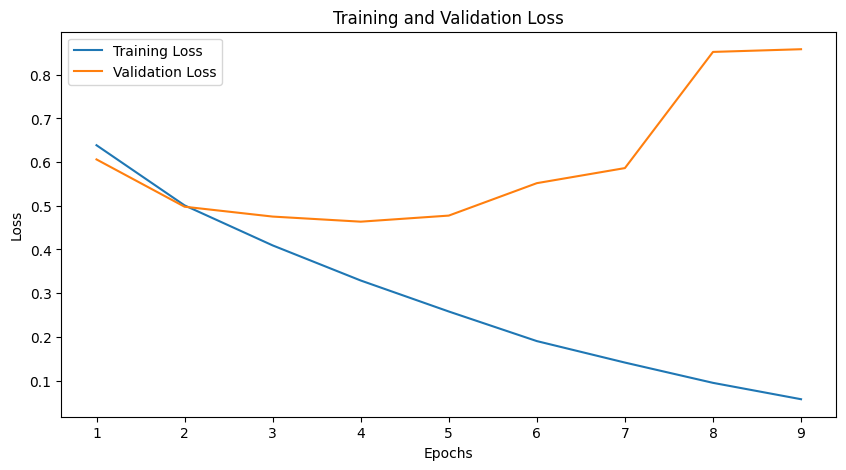

SentimentLSTM(
  (embedding): Embedding(18031, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
)

In [56]:
# Instantiate the model
biLSTM = SentimentLSTM(embedding_matrix)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
biLSTM.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(biLSTM.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5, verbose=True)

# Training loop with validation and early stopping
num_epochs = 30
patience = 5  # Early stopping patience

train_model(biLSTM,'bilstm', num_epochs, optimizer, scheduler, criterion, patience, train_loader, val_loader, device)

In [57]:
# Load the best model and evaluate on the test set
biLSTM.load_state_dict(torch.load('bilstm_model.pt'))
test_model(biLSTM,device, test_loader)

C:\Users\zheng\AppData\Local\Temp\ipykernel_49844\3829958270.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  biLSTM.load_state_dict(torch.load('bilstm_model.pt'))
100%|█

Accuracy Score on Test dataset: 0.8011


## Part 3.3.2 biGRU Model

In [58]:
class SentimentBiGRU(nn.Module):
    def __init__(self, embedding_matrix):
        super(SentimentBiGRU, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)
        self.gru = nn.GRU(embedding_dim, hidden_size=256, batch_first=True, bidirectional=True, num_layers=2, dropout=0.5)
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        embeds = self.embedding(x)
        gru_out, h_n = self.gru(embeds)
        
        # Concatenate the final hidden states from both directions
        out = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)
        
        out = self.dropout(out)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = torch.sigmoid(self.fc2(out))
        return out.squeeze()

In [59]:
# Load the dataset
dataset = load_dataset("rotten_tomatoes")
train_raw = dataset['train']
validation_raw = dataset['validation']
test_raw = dataset['test']

# Build the vocabulary from training data
vocabulary = set()
for text in train_raw['text']:
    tokens = word_tokenize(text.lower())
    vocabulary.update(tokens)

# Add special tokens
vocabulary.add('<unk>')
vocabulary.add('<pad>')

# Create mappings between words and indices
word2idx = {word: idx for idx, word in enumerate(vocabulary)}
idx2word = {idx: word for word, idx in word2idx.items()}

# Initialize the embedding matrix
embedding_dim = 100  # Dimensionality of GloVe embeddings
vocab_size = len(word2idx)
embedding_matrix = np.random.uniform(-0.05, 0.05, (vocab_size, embedding_dim))

# Load GloVe embeddings (ensure 'glove.6B.100d.txt' is in your working directory)
glove_path = 'glove.6B.100d.txt'  # Update the path if necessary
with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        if len(values) == embedding_dim + 1:
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            if word in word2idx:
                idx = word2idx[word]
                embedding_matrix[idx] = vector

# Set the embedding for '<pad>' token to zeros
pad_idx = word2idx['<pad>']
embedding_matrix[pad_idx] = np.zeros(embedding_dim)

100%|██████████| 9/9 [00:00<00:00, 42.58it/s]


Epoch [1/30], Training Loss: 0.6365, Validation Accuracy: 0.6998, Validation Loss: 0.6009, Best Val Loss: inf


100%|██████████| 9/9 [00:00<00:00, 39.93it/s]


Epoch [2/30], Training Loss: 0.5363, Validation Accuracy: 0.7392, Validation Loss: 0.5230, Best Val Loss: 0.6009


100%|██████████| 9/9 [00:00<00:00, 35.25it/s]


Epoch [3/30], Training Loss: 0.4197, Validation Accuracy: 0.7692, Validation Loss: 0.4879, Best Val Loss: 0.5230


100%|██████████| 9/9 [00:00<00:00, 35.95it/s]


Epoch [4/30], Training Loss: 0.3318, Validation Accuracy: 0.7608, Validation Loss: 0.5434, Best Val Loss: 0.4879


100%|██████████| 9/9 [00:00<00:00, 37.14it/s]


Epoch [5/30], Training Loss: 0.2373, Validation Accuracy: 0.7758, Validation Loss: 0.5227, Best Val Loss: 0.4879


100%|██████████| 9/9 [00:00<00:00, 38.56it/s]


Epoch [6/30], Training Loss: 0.1660, Validation Accuracy: 0.7514, Validation Loss: 0.6445, Best Val Loss: 0.4879


100%|██████████| 9/9 [00:00<00:00, 40.11it/s]


Epoch [7/30], Training Loss: 0.1198, Validation Accuracy: 0.7702, Validation Loss: 0.7574, Best Val Loss: 0.4879


100%|██████████| 9/9 [00:00<00:00, 35.39it/s]


Epoch [8/30], Training Loss: 0.0820, Validation Accuracy: 0.7739, Validation Loss: 0.8200, Best Val Loss: 0.4879
Early stopping!


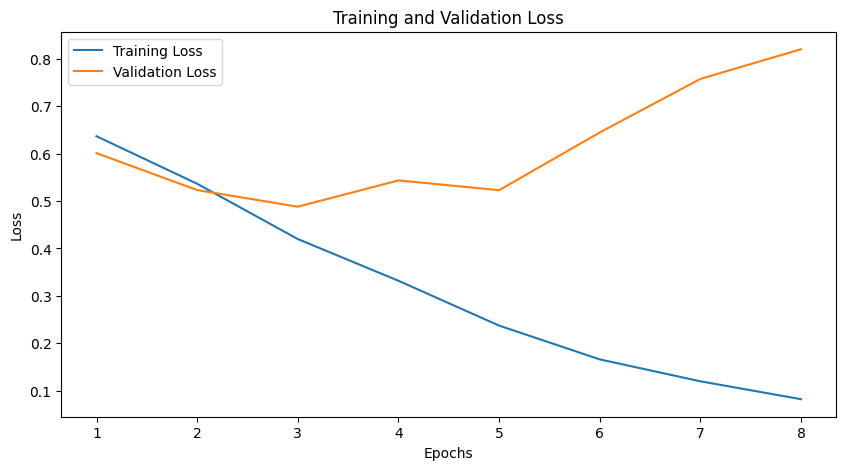

SentimentBiGRU(
  (embedding): Embedding(18031, 100)
  (gru): GRU(100, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
)

In [60]:
# Instantiate the model
biGRU_model = SentimentBiGRU(embedding_matrix)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
biGRU_model.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(biGRU_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5, verbose=True)

# Training loop with validation and early stopping
num_epochs = 30
patience = 5  # Early stopping patience

train_model(biGRU_model,'bigru', num_epochs, optimizer, scheduler, criterion, patience, train_loader, val_loader, device)

In [61]:
# Load the best model and evaluate on the test set
biGRU_model.load_state_dict(torch.load('bigru_model.pt'))
test_model(biGRU_model,device, test_loader)

C:\Users\zheng\AppData\Local\Temp\ipykernel_49844\992514502.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  biGRU_model.load_state_dict(torch.load('bigru_model.pt'))
100

Accuracy Score on Test dataset: 0.7880


## Part 3.4 Convolutional Neural Network

In [62]:
class SentimentCNN(nn.Module):
    def __init__(self, embedding_matrix):
        super(SentimentCNN, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)
        
        # 1D Convolution layers to capture local features
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=256, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, 1)
        
        # Other layers
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Input: (batch_size, sequence_length)
        embeds = self.embedding(x)  # (batch_size, sequence_length, embedding_dim)
        
        # Convolution expects input with shape (batch_size, embedding_dim, sequence_length)
        embeds = embeds.permute(0, 2, 1)
        
        # Apply convolution layers and ReLU activation
        conv_out = self.relu(self.conv1(embeds))  # (batch_size, 256, sequence_length)
        conv_out = self.relu(self.conv2(conv_out))  # (batch_size, 128, sequence_length)
        
        # Global Max Pooling (to reduce the sequence length dimension)
        pooled_out = torch.max(conv_out, dim=2)[0]  # (batch_size, 128)
        
        # Fully connected layers with dropout and ReLU
        out = self.dropout(pooled_out)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        
        # Sigmoid activation for binary classification
        out = torch.sigmoid(self.fc2(out))
        return out.squeeze()


In [63]:
# Load the dataset
dataset = load_dataset("rotten_tomatoes")
train_raw = dataset['train']
validation_raw = dataset['validation']
test_raw = dataset['test']

# Build the vocabulary from training data
vocabulary = set()
for text in train_raw['text']:
    tokens = word_tokenize(text.lower())
    vocabulary.update(tokens)

# Add special tokens
vocabulary.add('<unk>')
vocabulary.add('<pad>')

# Create mappings between words and indices
word2idx = {word: idx for idx, word in enumerate(vocabulary)}
idx2word = {idx: word for word, idx in word2idx.items()}

# Initialize the embedding matrix
embedding_dim = 100  # Dimensionality of GloVe embeddings
vocab_size = len(word2idx)
embedding_matrix = np.random.uniform(-0.05, 0.05, (vocab_size, embedding_dim))

# Load GloVe embeddings (ensure 'glove.6B.100d.txt' is in your working directory)
glove_path = 'glove.6B.100d.txt'  # Update the path if necessary
with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        if len(values) == embedding_dim + 1:
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            if word in word2idx:
                idx = word2idx[word]
                embedding_matrix[idx] = vector

# Set the embedding for '<pad>' token to zeros
pad_idx = word2idx['<pad>']
embedding_matrix[pad_idx] = np.zeros(embedding_dim)

100%|██████████| 9/9 [00:00<00:00, 54.04it/s]


Epoch [1/30], Training Loss: 0.6457, Validation Accuracy: 0.7111, Validation Loss: 0.5529, Best Val Loss: inf


100%|██████████| 9/9 [00:00<00:00, 56.53it/s]


Epoch [2/30], Training Loss: 0.5028, Validation Accuracy: 0.7186, Validation Loss: 0.5900, Best Val Loss: 0.5529


100%|██████████| 9/9 [00:00<00:00, 49.04it/s]


Epoch [3/30], Training Loss: 0.4147, Validation Accuracy: 0.7786, Validation Loss: 0.4868, Best Val Loss: 0.5529


100%|██████████| 9/9 [00:00<00:00, 53.08it/s]


Epoch [4/30], Training Loss: 0.3206, Validation Accuracy: 0.7880, Validation Loss: 0.4967, Best Val Loss: 0.4868


100%|██████████| 9/9 [00:00<00:00, 54.69it/s]


Epoch [5/30], Training Loss: 0.2260, Validation Accuracy: 0.7805, Validation Loss: 0.5714, Best Val Loss: 0.4868


100%|██████████| 9/9 [00:00<00:00, 50.41it/s]


Epoch [6/30], Training Loss: 0.1396, Validation Accuracy: 0.7758, Validation Loss: 0.6673, Best Val Loss: 0.4868


100%|██████████| 9/9 [00:00<00:00, 53.08it/s]


Epoch [7/30], Training Loss: 0.0772, Validation Accuracy: 0.7627, Validation Loss: 0.8731, Best Val Loss: 0.4868


100%|██████████| 9/9 [00:00<00:00, 51.27it/s]


Epoch [8/30], Training Loss: 0.0419, Validation Accuracy: 0.7598, Validation Loss: 1.0270, Best Val Loss: 0.4868
Early stopping!


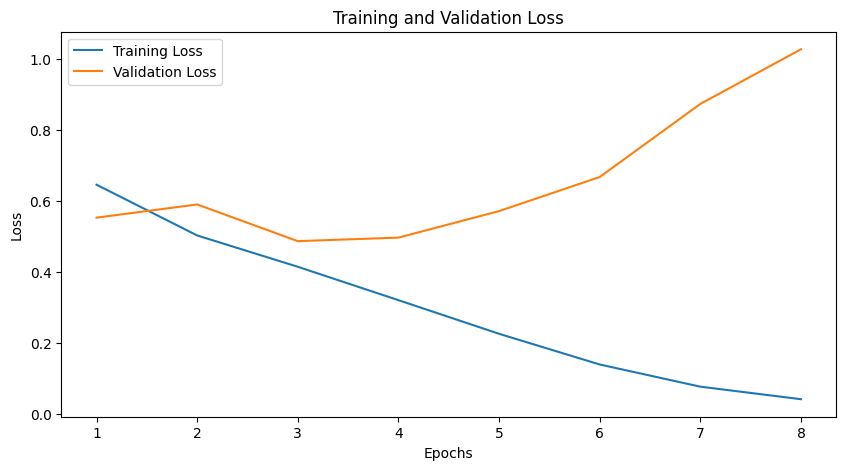

SentimentCNN(
  (embedding): Embedding(18031, 100)
  (conv1): Conv1d(100, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
)

In [64]:
# Instantiate the model
cnn_model = SentimentCNN(embedding_matrix)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_model.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5, verbose=True)

# Training loop with validation and early stopping
num_epochs = 30
patience = 5  # Early stopping patience

train_model(cnn_model,'cnn', num_epochs, optimizer, scheduler, criterion, patience, train_loader, val_loader, device)

In [65]:
# Load the best model and evaluate on the test set
cnn_model.load_state_dict(torch.load('cnn_model.pt'))
test_model(cnn_model,device, test_loader)

C:\Users\zheng\AppData\Local\Temp\ipykernel_49844\3531505752.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model.load_state_dict(torch.load('cnn_model.pt'))
100%|█

Accuracy Score on Test dataset: 0.7917


#

## Part 3.5 Improve Model

### Part 3.5.1 Improvement Strategy 1: BERT

In [66]:
nltk.download('punkt')

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zheng\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [67]:
# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [68]:
# Load the dataset
dataset = load_dataset("rotten_tomatoes")
train_raw = dataset['train']
validation_raw = dataset['validation']
test_raw = dataset['test']

In [69]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define maximum sequence length
MAX_LEN = 128

# Define the custom Dataset class for BERT
class BERTSentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.float)
        }

In [70]:
# Create datasets for training, validation, and testing
train_dataset = BERTSentimentDataset(
    texts=train_raw['text'],
    labels=train_raw['label'],
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

val_dataset = BERTSentimentDataset(
    texts=validation_raw['text'],
    labels=validation_raw['label'],
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_dataset = BERTSentimentDataset(
    texts=test_raw['text'],
    labels=test_raw['label'],
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

In [71]:
# Define the DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=1,  # Binary classification
    output_attentions=False,
    output_hidden_states=False
)

model.to(device)

# Define optimizer with weight decay
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Total number of training steps
total_steps = len(train_loader) * 10  # Assuming 10 epochs

# Create the learning rate scheduler with warm-up
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Define loss function
criterion = torch.nn.BCEWithLogitsLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\zheng\anaconda3\envs\nlp2\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [72]:
# Function to calculate metrics
def bert_evaluate(model, data_loader):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits.squeeze()
            preds = torch.sigmoid(logits)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Convert predictions to binary
    binary_preds = [1 if p >= 0.5 else 0 for p in predictions]

    acc = accuracy_score(true_labels, binary_preds)
    f1 = f1_score(true_labels, binary_preds)

    return acc, f1

In [73]:
# Training loop with validation and early stopping
num_epochs = 10
patience = 3
best_val_f1 = 0
epochs_no_improve = 0
best_model_path = 'best_bert_model.pt'

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits.squeeze()

        loss = criterion(logits, labels)
        total_loss += loss.item()

        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_loader)

    # Validation
    val_accuracy, val_f1 = bert_evaluate(model, val_loader)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Training Loss: {avg_train_loss:.4f}')
    print(f'Validation Accuracy: {val_accuracy:.4f}')
    print(f'Validation F1 Score: {val_f1:.4f}')

    # Check for improvement
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print('Validation F1 improved, saving model.')
    else:
        epochs_no_improve += 1
        print(f'No improvement in validation F1 for {epochs_no_improve} epoch(s).')
        if epochs_no_improve >= patience:
            print('Early stopping triggered!')
            break

# Load the best model
model.load_state_dict(torch.load(best_model_path))
model.to(device)

# Evaluate on test set
test_accuracy, test_f1 = bert_evaluate(model, test_loader)
print(f'\nTest Accuracy: {test_accuracy:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')

Epoch 1/10
Training Loss: 0.4092
Validation Accuracy: 0.8527
Validation F1 Score: 0.8542
Validation F1 improved, saving model.
Epoch 2/10
Training Loss: 0.2156
Validation Accuracy: 0.8537
Validation F1 Score: 0.8582
Validation F1 improved, saving model.
Epoch 3/10
Training Loss: 0.1167
Validation Accuracy: 0.8687
Validation F1 Score: 0.8699
Validation F1 improved, saving model.
Epoch 4/10
Training Loss: 0.0673
Validation Accuracy: 0.8602
Validation F1 Score: 0.8637
No improvement in validation F1 for 1 epoch(s).
Epoch 5/10
Training Loss: 0.0377
Validation Accuracy: 0.8687
Validation F1 Score: 0.8708
Validation F1 improved, saving model.
Epoch 6/10
Training Loss: 0.0209
Validation Accuracy: 0.8602
Validation F1 Score: 0.8634
No improvement in validation F1 for 1 epoch(s).
Epoch 7/10
Training Loss: 0.0094
Validation Accuracy: 0.8687
Validation F1 Score: 0.8672
No improvement in validation F1 for 2 epoch(s).
Epoch 8/10
Training Loss: 0.0100
Validation Accuracy: 0.8668
Validation F1 Score:

C:\Users\zheng\AppData\Local\Temp\ipykernel_49844\2881863280.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))



Test Accuracy: 0.8443
Test F1 Score: 0.8446


### Part 3.5.2 Improvement Strategy 2: Modified GloVe Embeddings with Sentiment Scores

In [74]:
afinn = Afinn()

# Function to fetch sentiment score
def get_sentiment_score(word):
    return afinn.score(word)

In [75]:
nltk.download('punkt')

# Load the dataset
dataset = load_dataset("rotten_tomatoes")
train_raw = dataset['train']
validation_raw = dataset['validation']
test_raw = dataset['test']

# Build the vocabulary from training data
vocabulary = set()
for text in train_raw['text']:
    tokens = word_tokenize(text.lower())
    vocabulary.update(tokens)

# Add special tokens
vocabulary.add('<unk>')
vocabulary.add('<pad>')

# Create mappings between words and indices
word2idx = {word: idx for idx, word in enumerate(vocabulary)}
idx2word = {idx: word for word, idx in word2idx.items()}

# Initialize the embedding matrix with an extra dimension for sentiment scores
embedding_dim = 100 + 1  # Original dimensionality of GloVe embeddings + 1 for sentiment score
vocab_size = len(word2idx)
# embedding_matrix = np.zeros((vocab_size, embedding_dim))  # Initialize with zeros
embedding_matrix = np.random.uniform(-0.05, 0.05, (vocab_size, embedding_dim))

# Load GloVe embeddings and include sentiment scores
glove_path = 'glove.6B.100d.txt'  # Make sure the path is correct
with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        if len(values) == embedding_dim:  # This should be just the embedding dimensions without sentiment score
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            if word in word2idx:
                idx = word2idx[word]
                embedding_matrix[idx, :-1] = vector  # Exclude the last dimension for sentiment score
                embedding_matrix[idx, -1] = get_sentiment_score(word)  # Add sentiment score in the last dimension

# Set the embedding for '<pad>' token to zeros (including sentiment score)
pad_idx = word2idx['<pad>']
embedding_matrix[pad_idx] = np.zeros(embedding_dim)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zheng\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [76]:
# Create datasets for training, validation, and testing
train_dataset = SentimentDataset(train_raw['text'], train_raw['label'], word2idx)
val_dataset = SentimentDataset(validation_raw['text'], validation_raw['label'], word2idx)
test_dataset = SentimentDataset(test_raw['text'], test_raw['label'], word2idx)

# Create DataLoaders for training, validation, and testing
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [77]:
class SentimentLSTM(nn.Module):
    def __init__(self, embedding_matrix):
        super(SentimentLSTM, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze= False)
        self.lstm = nn.LSTM(embedding_dim, hidden_size=256, batch_first=True, bidirectional=True, num_layers=1, dropout=0.5)
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, (h_n, c_n) = self.lstm(embeds)

        out, _ = torch.max(lstm_out, dim=1)
        # Concatenate the final hidden states from both directions
        # out = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)
        
        out = self.dropout(out)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = torch.sigmoid(self.fc2(out))
        return out.squeeze()

c:\Users\zheng\anaconda3\envs\nlp2\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
100%|██████████| 9/9 [00:00<00:00, 41.39it/s]


Epoch [1/30], Training Loss: 0.6053, Validation Accuracy: 0.7289, Validation Loss: 0.5367, Best Val Loss: inf


100%|██████████| 9/9 [00:00<00:00, 39.93it/s]


Epoch [2/30], Training Loss: 0.4732, Validation Accuracy: 0.7758, Validation Loss: 0.4782, Best Val Loss: 0.5367


100%|██████████| 9/9 [00:00<00:00, 44.90it/s]


Epoch [3/30], Training Loss: 0.3939, Validation Accuracy: 0.7617, Validation Loss: 0.4814, Best Val Loss: 0.4782


100%|██████████| 9/9 [00:00<00:00, 38.90it/s]


Epoch [4/30], Training Loss: 0.3381, Validation Accuracy: 0.7458, Validation Loss: 0.5899, Best Val Loss: 0.4782


100%|██████████| 9/9 [00:00<00:00, 43.18it/s]


Epoch [5/30], Training Loss: 0.2581, Validation Accuracy: 0.7702, Validation Loss: 0.4931, Best Val Loss: 0.4782


100%|██████████| 9/9 [00:00<00:00, 42.77it/s]


Epoch [6/30], Training Loss: 0.1750, Validation Accuracy: 0.7842, Validation Loss: 0.5681, Best Val Loss: 0.4782


100%|██████████| 9/9 [00:00<00:00, 39.93it/s]


Epoch [7/30], Training Loss: 0.1288, Validation Accuracy: 0.7805, Validation Loss: 0.6163, Best Val Loss: 0.4782
Early stopping!


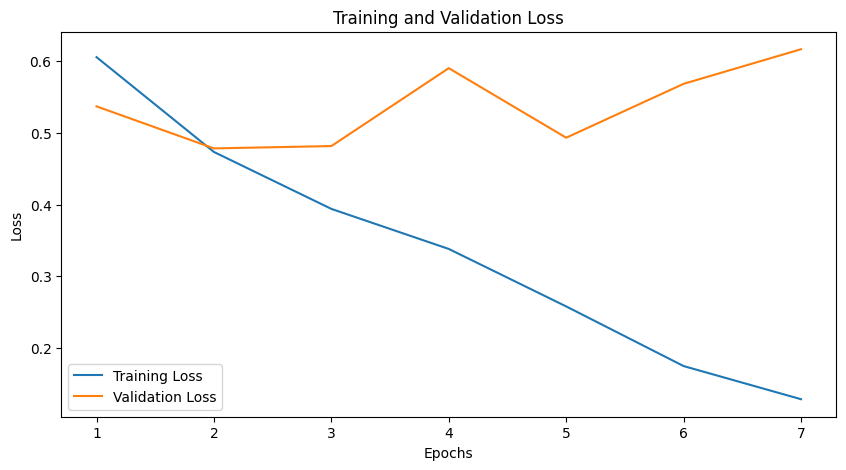

SentimentLSTM(
  (embedding): Embedding(18031, 101)
  (lstm): LSTM(101, 256, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
)

In [78]:
# Instantiate the model
biLSTM = SentimentLSTM(embedding_matrix)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
biLSTM.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(biLSTM.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5, verbose=True)

# Training loop with validation and early stopping
num_epochs = 30
patience = 5  # Early stopping patience

train_model(biLSTM,'bilstm', num_epochs, optimizer, scheduler, criterion, patience, train_loader, val_loader, device)

In [79]:
# Load the best model and evaluate on the test set
biLSTM.load_state_dict(torch.load('bilstm_model.pt'))
test_model(biLSTM,device, test_loader)

C:\Users\zheng\AppData\Local\Temp\ipykernel_49844\3829958270.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  biLSTM.load_state_dict(torch.load('bilstm_model.pt'))
100%|█

Accuracy Score on Test dataset: 0.7936
